## 2a. Segmentation

The segmentation stage focuses on lesion delineation using a U-Net++ architecture, starting from the same train/validation split to avoid data leakage.

In [1]:
# ============================================================
# CELL 1 - IMPORTS AND GLOBAL SETUP
# ============================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Reproducibility seed shared across libraries
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("Libraries imported and random seed configured.")

Libraries imported and random seed configured.


In [ ]:
# ============================================================
# CELL 1 - ENVIRONMENT SETUP AND SOTA LIBRARIES
# ============================================================
# Install the standard library used for advanced segmentation models (left in place for notebook reproducibility)
!pip install segmentation_models_pytorch -q

import segmentation_models_pytorch as smp

# Reuse the global random seed for segmentation experiments
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Configuration
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"
IMAGES_ROOT = "/kaggle/input/tumor-segmentation-ai/training_images/training_images"
IMG_SIZE = 320       # Resolution for U-Net++ with EfficientNet-B7 encoder (multiple of 32)
BATCH_SIZE = 16      # Increased batch size for 320x320 on 2x T4 GPU (16GB each)
NUM_EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"U-Net++ setup initialised on {device}.")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

MAnet setup initialised on cuda.


**Segmentation Stage Overview.** The following cells mirror the classification split, remove healthy cases only after the split to eliminate leakage, and configure U-Net++ with nested skip pathways for lesion delineation.

In [ ]:
# ============================================================
# CELL 2 - DATASET (ALL CLASSES) + SAMPLER
# ============================================================

# 1. Load all data (Task 2a: N+B+M - all 3 classes for segmentation)
df_full = pd.read_excel(EXCEL_PATH)
df_full = df_full.dropna(subset=['US', 'LABEL', 'MASK']).reset_index(drop=True)

# 2. Split (same seed as classifier to ensure consistency)
train_df, val_df = train_test_split(df_full, stratify=df_full['LABEL'], test_size=0.2, random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")

# 3. Dataset class definition
class SegmentationDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, str(self.df.loc[idx, "US"]))
        mask_path = os.path.join(self.root, str(self.df.loc[idx, "MASK"]))
        
        try:
            image = np.array(Image.open(img_path).convert("RGB"))
            # For "Normal" cases, the mask will be black (all zeros)
            mask = np.array(Image.open(mask_path).convert("L"))
        except:
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
            mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

        mask = np.where(mask > 0, 1.0, 0.0).astype(np.float32)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
        mask = mask.unsqueeze(0) 
        return image, mask

# 4. Augmentation (Aligned with notebook 1b for fair comparison)
# Deformations are essential for segmentation to simulate probe pressure and biological variability
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    
    # --- GEOMETRIC (Probe movement simulation) ---
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    
    # --- PHYSICAL DEFORMATIONS (Essential for segmentation!) ---
    # Simulate probe pressure and biological variability
    # Reduced alpha for 320x320 (scales better with smaller images)
    A.ElasticTransform(alpha=80, sigma=80 * 0.05, p=0.4),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    
    # --- TEXTURE & NOISE (Speckle Noise simulation) ---
    # Essential for generalizing across different ultrasound machines
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    
    # --- CONTRAST (Edge visibility) ---
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    
    # --- FINAL NORMALIZATION ---
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 5. Sampler (Class balancing: N, B, M)
# Compute weights to give equal importance to healthy and diseased samples
class_counts = train_df['LABEL'].value_counts().sort_index()
class_weights = 1.0 / class_counts
sample_weights = train_df['LABEL'].map(class_weights).values
sample_weights = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_df), replacement=True)
print("Sampler Active: Training balanced across Normal, Benign, and Malignant!")

# 6. DataLoaders
train_loader = DataLoader(
    SegmentationDataset(train_df, IMAGES_ROOT, train_transform), 
    batch_size=BATCH_SIZE, 
    sampler=sampler, 
    shuffle=False, 
    num_workers=2, 
    drop_last=True
)

val_loader = DataLoader(
    SegmentationDataset(val_df, IMAGES_ROOT, val_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2
)

print("✅ Dataloaders ready.")

Train: 1202 | Val: 301
Sampler Attivo: Training bilanciato tra Normali, Benigni e Maligni!
✅ Dataloaders pronti.


/tmp/ipykernel_154/2340248986.py:61: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=80, sigma=80 * 0.05, alpha_affine=None, p=0.4),
/tmp/ipykernel_154/2340248986.py:66: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
# ============================================================
# CELL 3 - SOTA MODEL: U-NET++
# ============================================================

# U-Net++ with Nested Skip Pathways is widely considered SOTA for medical segmentation.
# It bridges the semantic gap between encoder and decoder more effectively than standard U-Net.

ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
ACTIVATION = None

# Switching to UnetPlusPlus
model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=CLASSES,
    activation=ACTIVATION,
    decoder_channels=(256, 128, 64, 32, 16), # Classic high-res decoder
    decoder_attention_type=None,
    deep_supervision=True
)

if torch.cuda.device_count() > 1:
    print(f"🔥 {torch.cuda.device_count()} GPUs active! DataParallel ON.")
    model = nn.DataParallel(model)

model = model.to(device)

print(f"🚀 SOTA Model U-Net++ initialized with {ENCODER} backbone.")

🔥 2 GPU attive! DataParallel ON.
🚀 SOTA Model U-Net++ initialized with efficientnet-b7 backbone.


### Optimisation Scheme
The next block defines the hybrid Dice–Focal loss, an adaptive learning-rate schedule, and an early-stopping routine tuned to maximise validation Dice.

In [ ]:
# ============================================================
# CELL 4 - SOTA TRAINING (U-NET++ DETAILED)
# ============================================================

# 1. Hybrid Loss Definition (Dice + Focal + Boundary)
loss_dice = smp.losses.DiceLoss(mode='binary', from_logits=True)
loss_focal = smp.losses.FocalLoss(mode='binary')
loss_boundary = smp.losses.LovaszLoss(mode='binary', from_logits=True)  # Boundary-aware loss

def criterion(preds, target):
    # When deep supervision is active, preds is a list of tensors
    if isinstance(preds, list):
        loss = 0
        # Compute loss for each output and average
        # Weights: Dice 0.4 (region), Focal 0.3 (hard examples), Boundary 0.3 (edges)
        for p in preds:
            loss += 0.4 * loss_dice(p, target) + 0.3 * loss_focal(p, target) + 0.3 * loss_boundary(p, target)
        return loss / len(preds)
    else:
        return 0.4 * loss_dice(preds, target) + 0.3 * loss_focal(preds, target) + 0.3 * loss_boundary(preds, target)

# 2. Smart Dice Metric (for Training and Validation)
def dice_metric_smart(pred, target):
    # Handle deep supervision output - take main output if list
    if isinstance(pred, list):
        pred = pred[0]
    pred = (torch.sigmoid(pred) > 0.5).float()
    if pred.sum() == 0 and target.sum() == 0: return 1.0
    intersection = (pred * target).sum()
    return ((2. * intersection) / (pred.sum() + target.sum() + 1e-7)).item()

# 3. Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

EARLY_STOP_PATIENCE = 15
patience_counter = 0
best_dice = 0

# Complete history for plotting
history = {
    'train_loss': [], 
    'val_loss': [],     # Added val_loss
    'train_dice': [],   # Added train_dice
    'val_dice': []
}

print("🚀 Starting SOTA Training (U-Net++ with Boundary Loss)...")

for epoch in range(NUM_EPOCHS):
    model.train()
    t_loss = 0
    t_dice = 0
    
    # Training Loop
    for i, (img, mask) in enumerate(train_loader):
        img, mask = img.to(device), mask.to(device)
        
        optimizer.zero_grad()
        out = model(img)
        
        # DEEP SUPERVISION: Pass full output (list) to criterion for multi-scale loss
        # The criterion handles both list and tensor inputs
        loss = criterion(out, mask)
        loss.backward()
        optimizer.step()
        
        # Compute batch metrics (dice_metric_smart handles list internally)
        loss_val = loss.item()
        dice_val = dice_metric_smart(out, mask)
        
        t_loss += loss_val
        t_dice += dice_val
        
        # Intermediate progress print
        if (i + 1) % 10 == 0:
            print(f"    [Ep {epoch+1}] Batch {i+1}/{len(train_loader)} | Loss: {loss_val:.4f} | Train Dice: {dice_val:.4f}")
            
    # Training averages
    avg_t_loss = t_loss / len(train_loader)
    avg_t_dice = t_dice / len(train_loader)
    
    # Validation Loop
    model.eval()
    v_loss = 0
    v_dice = 0
    
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            
            # DEEP SUPERVISION: Use full output for validation loss too
            v_loss += criterion(out, mask).item()
            v_dice += dice_metric_smart(out, mask)
            
    avg_v_loss = v_loss / len(val_loader)
    avg_v_dice = v_dice / len(val_loader)
    
    # Scheduler & History
    scheduler.step(avg_v_dice)
    
    history['train_loss'].append(avg_t_loss)
    history['val_loss'].append(avg_v_loss)
    history['train_dice'].append(avg_t_dice)
    history['val_dice'].append(avg_v_dice)
    
    print(f"🔵 END EP {epoch+1} | T.Loss: {avg_t_loss:.4f} | V.Loss: {avg_v_loss:.4f} | T.Dice: {avg_t_dice:.4f} | V.Dice: {avg_v_dice:.4f}")
    
    # Checkpoint
    if avg_v_dice > best_dice:
        best_dice = avg_v_dice
        save_obj = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save(save_obj, "best_unet_plusplus_b7.pt")
        print("  ✓ Saved Best Model")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")
        if patience_counter >= EARLY_STOP_PATIENCE:
            print("❌ Early Stopping")
            break

print(f"🏆 Best SOTA Validation Dice: {best_dice:.4f}")

🚀 Avvio Training SOTA (U-Net++)...
    [Ep 1] Batch 10/75 | Loss: 0.5500 | Train Dice: 0.1242
    [Ep 1] Batch 20/75 | Loss: 0.5194 | Train Dice: 0.1290
    [Ep 1] Batch 30/75 | Loss: 0.4828 | Train Dice: 0.2348
    [Ep 1] Batch 40/75 | Loss: 0.5122 | Train Dice: 0.1663
    [Ep 1] Batch 50/75 | Loss: 0.5261 | Train Dice: 0.2419
    [Ep 1] Batch 60/75 | Loss: 0.4223 | Train Dice: 0.6143
    [Ep 1] Batch 70/75 | Loss: 0.4048 | Train Dice: 0.6458
🔵 FINE EP 1 | T.Loss: 0.4880 | V.Loss: 0.4388 | T.Dice: 0.3234 | V.Dice: 0.6088
  ✓ Saved Best Model
    [Ep 2] Batch 10/75 | Loss: 0.4250 | Train Dice: 0.5210
    [Ep 2] Batch 20/75 | Loss: 0.4014 | Train Dice: 0.5818
    [Ep 2] Batch 30/75 | Loss: 0.4180 | Train Dice: 0.6371
    [Ep 2] Batch 40/75 | Loss: 0.4691 | Train Dice: 0.3834
    [Ep 2] Batch 50/75 | Loss: 0.3823 | Train Dice: 0.6038
    [Ep 2] Batch 60/75 | Loss: 0.4141 | Train Dice: 0.6716
    [Ep 2] Batch 70/75 | Loss: 0.3781 | Train Dice: 0.6990
🔵 FINE EP 2 | T.Loss: 0.4120 | V.Loss:

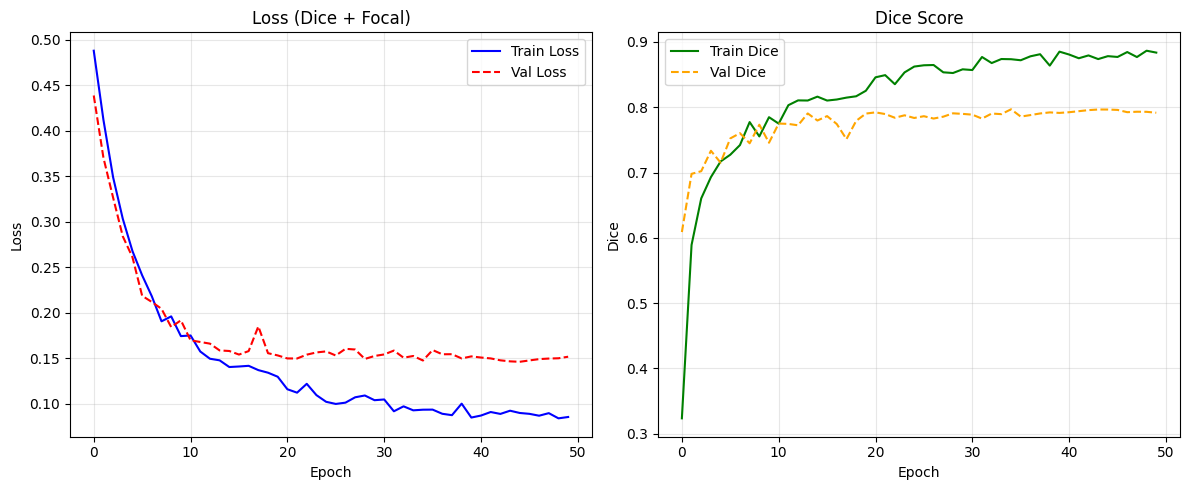

In [ ]:
# ============================================================
# CELL EXTRA - TRAINING PROGRESS PLOTS
# ============================================================

plt.figure(figsize=(12, 5))

# 1. Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
plt.title('Loss (Dice + Focal)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Dice Score Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice', color='green')
plt.plot(history['val_dice'], label='Val Dice', color='orange', linestyle='--')
plt.title('Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Qualitative Validation Samples
After training, we reload the best checkpoint and display representative ultrasound slices alongside ground-truth and predicted masks with per-case Dice scores.

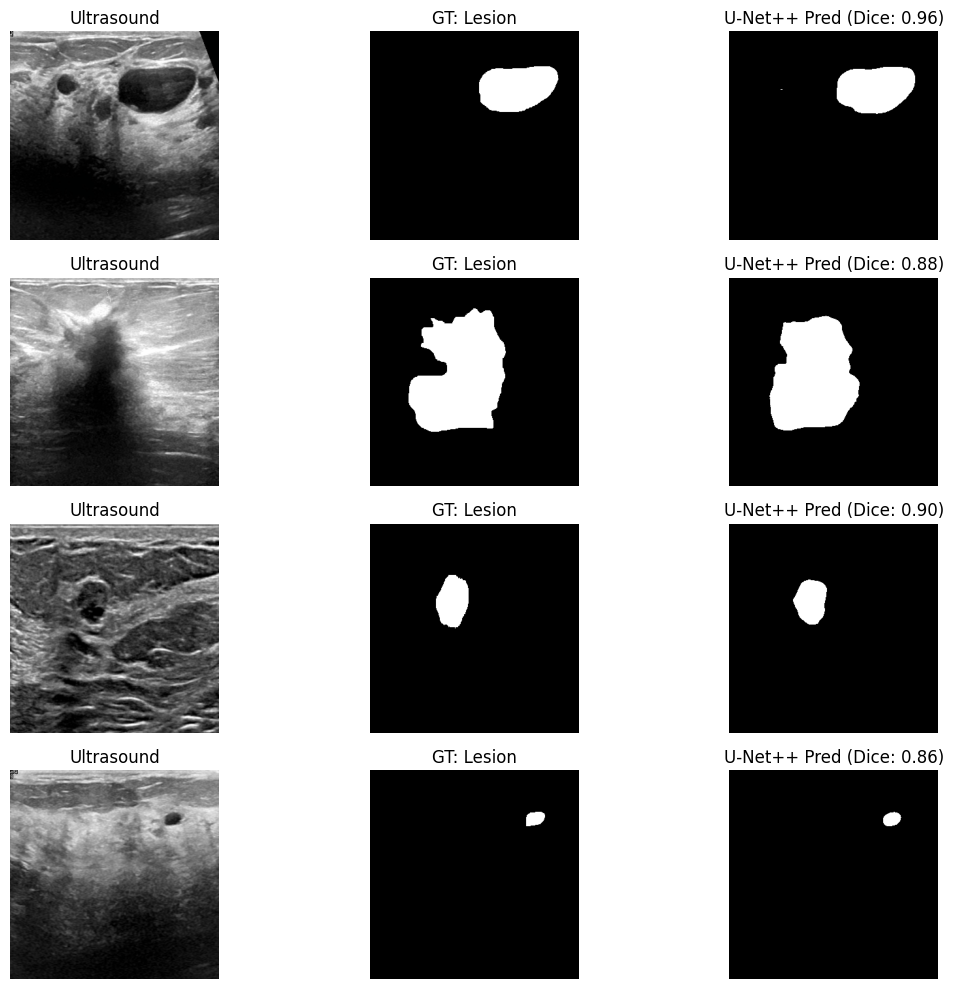

In [ ]:
# ============================================================
# CELL 5 - VISUALIZATION
# ============================================================
# Recreate the model with the EXACT same architecture used during training
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    in_channels=3, 
    classes=1,
    decoder_channels=(256, 128, 64, 32, 16),
    decoder_attention_type=None,
    deep_supervision=True
)
model.load_state_dict(torch.load("best_unet_plusplus_b7.pt"))
model = model.to(device)
model.eval()

img, mask = next(iter(val_loader))
img, mask = img.to(device), mask.to(device)

with torch.no_grad():
    pred_logits = model(img)
    # Handle deep supervision output
    if isinstance(pred_logits, list):
        pred_logits = pred_logits[0]
    pred_mask = (torch.sigmoid(pred_logits) > 0.5).float()

plt.figure(figsize=(12, 10))
for i in range(4): 
    plt.subplot(4, 3, i*3 + 1)
    im_np = img[i].cpu().permute(1,2,0).numpy()
    im_np = im_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(np.clip(im_np, 0, 1))
    plt.title("Ultrasound")
    plt.axis('off')
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(mask[i].cpu().squeeze(), cmap='gray')
    label_str = "Normal" if mask[i].sum() == 0 else "Lesion"
    plt.title(f"GT: {label_str}")
    plt.axis('off')

    plt.subplot(4, 3, i*3 + 3)
    score = dice_metric_smart(pred_logits[i:i+1], mask[i:i+1])
    plt.imshow(pred_mask[i].cpu().squeeze(), cmap='gray')
    plt.title(f"U-Net++ Pred (Dice: {score:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 📊 Comprehensive Segmentation Analysis for Academic Paper
The following cells provide detailed statistical analysis, publication-quality visualizations, and comprehensive metrics required for scientific reporting of the U-Net++ segmentation model performance.

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 1: COMPREHENSIVE METRICS COMPUTATION
# ============================================================

# Reload model for evaluation
model_eval_seg = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    in_channels=3, 
    classes=1,
    decoder_channels=(256, 128, 64, 32, 16),
    deep_supervision=False
)
model_eval_seg.load_state_dict(torch.load("best_unet_plusplus_b7.pt"))
model_eval_seg = model_eval_seg.to(device)
model_eval_seg.eval()

# Collect predictions and compute multiple metrics
all_dice = []
all_iou = []
all_precision = []
all_recall = []
all_specificity = []
lesion_areas_gt = []
lesion_areas_pred = []

def compute_segmentation_metrics(pred, target, smooth=1e-7):
    """Compute comprehensive segmentation metrics."""
    pred_binary = (torch.sigmoid(pred) > 0.5).float()
    
    # Flatten for metric computation
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    
    # True positives, false positives, false negatives, true negatives
    tp = (pred_flat * target_flat).sum()
    fp = (pred_flat * (1 - target_flat)).sum()
    fn = ((1 - pred_flat) * target_flat).sum()
    tn = ((1 - pred_flat) * (1 - target_flat)).sum()
    
    # Dice coefficient
    dice = (2 * tp + smooth) / (2 * tp + fp + fn + smooth)
    
    # IoU (Jaccard Index)
    iou = (tp + smooth) / (tp + fp + fn + smooth)
    
    # Precision (Positive Predictive Value)
    precision = (tp + smooth) / (tp + fp + smooth)
    
    # Recall (Sensitivity)
    recall = (tp + smooth) / (tp + fn + smooth)
    
    # Specificity
    specificity = (tn + smooth) / (tn + fp + smooth)
    
    return {
        'dice': dice.item(),
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'specificity': specificity.item(),
        'tp': tp.item(),
        'fp': fp.item(),
        'fn': fn.item(),
        'tn': tn.item()
    }

print("Computing comprehensive segmentation metrics...")
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(val_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model_eval_seg(images)
        
        for i in range(images.shape[0]):
            pred = outputs[i:i+1]
            target = masks[i:i+1]
            
            # Skip entirely empty ground truth masks (healthy cases)
            if target.sum() == 0:
                continue
            
            metrics = compute_segmentation_metrics(pred, target)
            all_dice.append(metrics['dice'])
            all_iou.append(metrics['iou'])
            all_precision.append(metrics['precision'])
            all_recall.append(metrics['recall'])
            all_specificity.append(metrics['specificity'])
            
            # Lesion areas
            pred_binary = (torch.sigmoid(pred) > 0.5).float()
            lesion_areas_gt.append(target.sum().item())
            lesion_areas_pred.append(pred_binary.sum().item())

print(f"Evaluated {len(all_dice)} lesion cases.")

# Convert to numpy
all_dice = np.array(all_dice)
all_iou = np.array(all_iou)
all_precision = np.array(all_precision)
all_recall = np.array(all_recall)
all_specificity = np.array(all_specificity)
lesion_areas_gt = np.array(lesion_areas_gt)
lesion_areas_pred = np.array(lesion_areas_pred)

# Print comprehensive statistics
print("\n" + "="*80)
print("COMPREHENSIVE SEGMENTATION METRICS SUMMARY")
print("="*80)
print(f"\n{'Metric':<20} {'Mean':<12} {'Std':<12} {'Median':<12} {'Min':<10} {'Max':<10}")
print("-"*80)
metrics_data = [
    ('Dice Score', all_dice),
    ('IoU (Jaccard)', all_iou),
    ('Precision', all_precision),
    ('Recall (Sens.)', all_recall),
    ('Specificity', all_specificity)
]
for name, data in metrics_data:
    print(f"{name:<20} {np.mean(data):<12.4f} {np.std(data):<12.4f} "
          f"{np.median(data):<12.4f} {np.min(data):<10.4f} {np.max(data):<10.4f}")
print("-"*80)

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 2: METRIC DISTRIBUTIONS
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Dice Score Distribution
ax1 = axes[0, 0]
ax1.hist(all_dice, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(all_dice), color='red', linestyle='--', lw=2, 
            label=f'Mean: {np.mean(all_dice):.4f}')
ax1.axvline(np.median(all_dice), color='green', linestyle='-.', lw=2, 
            label=f'Median: {np.median(all_dice):.4f}')
ax1.set_xlabel('Dice Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Dice Score Distribution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. IoU Distribution
ax2 = axes[0, 1]
ax2.hist(all_iou, bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.axvline(np.mean(all_iou), color='red', linestyle='--', lw=2, 
            label=f'Mean: {np.mean(all_iou):.4f}')
ax2.set_xlabel('IoU (Jaccard Index)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('IoU Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Precision vs Recall
ax3 = axes[0, 2]
ax3.scatter(all_recall, all_precision, alpha=0.6, c=all_dice, cmap='RdYlGn', s=50)
cbar = plt.colorbar(ax3.collections[0], ax=ax3)
cbar.set_label('Dice Score', fontsize=10)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax3.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision vs Recall (colored by Dice)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1.05])
ax3.set_ylim([0, 1.05])

# 4. Boxplot of all metrics
ax4 = axes[1, 0]
metrics_boxplot = [all_dice, all_iou, all_precision, all_recall, all_specificity]
bp = ax4.boxplot(metrics_boxplot, labels=['Dice', 'IoU', 'Precision', 'Recall', 'Specificity'],
                 patch_artist=True)
colors_bp = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Metric Distributions Comparison', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0, 1.05])

# 5. Lesion Area: Ground Truth vs Predicted
ax5 = axes[1, 1]
ax5.scatter(lesion_areas_gt, lesion_areas_pred, alpha=0.6, c='#3498db', s=50)
max_area = max(lesion_areas_gt.max(), lesion_areas_pred.max())
ax5.plot([0, max_area], [0, max_area], 'r--', lw=2, label='Perfect correlation')
ax5.set_xlabel('Ground Truth Lesion Area (pixels)', fontsize=12)
ax5.set_ylabel('Predicted Lesion Area (pixels)', fontsize=12)
ax5.set_title('Lesion Area: GT vs Predicted', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Compute correlation
from scipy import stats
corr, p_value = stats.pearsonr(lesion_areas_gt, lesion_areas_pred)
ax5.annotate(f'r = {corr:.4f}\np < {p_value:.2e}', xy=(0.05, 0.85), xycoords='axes fraction',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 6. Dice vs Lesion Size
ax6 = axes[1, 2]
ax6.scatter(lesion_areas_gt, all_dice, alpha=0.6, c='#9b59b6', s=50)
ax6.set_xlabel('Ground Truth Lesion Area (pixels)', fontsize=12)
ax6.set_ylabel('Dice Score', fontsize=12)
ax6.set_title('Dice Score vs Lesion Size', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(lesion_areas_gt, all_dice, 1)
p = np.poly1d(z)
x_trend = np.linspace(lesion_areas_gt.min(), lesion_areas_gt.max(), 100)
ax6.plot(x_trend, p(x_trend), 'r--', lw=2, label='Trend line')
ax6.legend(fontsize=10)

plt.tight_layout()
plt.savefig('segmentation_metric_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print correlation analysis
print("\n" + "="*70)
print("CORRELATION ANALYSIS")
print("="*70)
print(f"\nLesion Area (GT vs Predicted):")
print(f"  Pearson correlation: r = {corr:.4f}")
print(f"  P-value: {p_value:.2e}")
print(f"  Interpretation: {'Strong' if abs(corr) > 0.7 else 'Moderate' if abs(corr) > 0.5 else 'Weak'} correlation")

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 3: TRAINING DYNAMICS
# ============================================================

# Rename history to avoid conflict with classification history
seg_history = history

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(seg_history['train_loss']) + 1)

# 1. Loss curves with smoothing
ax1 = axes[0, 0]

def smooth(y, factor=0.9):
    smoothed = []
    for i, val in enumerate(y):
        if i == 0:
            smoothed.append(val)
        else:
            smoothed.append(factor * smoothed[-1] + (1 - factor) * val)
    return smoothed

ax1.plot(epochs, seg_history['train_loss'], alpha=0.3, color='blue')
ax1.plot(epochs, seg_history['val_loss'], alpha=0.3, color='red')
ax1.plot(epochs, smooth(seg_history['train_loss']), color='blue', lw=2.5, label='Train Loss (smoothed)')
ax1.plot(epochs, smooth(seg_history['val_loss']), color='red', lw=2.5, label='Val Loss (smoothed)')
best_epoch_loss = np.argmin(seg_history['val_loss']) + 1
ax1.axvline(x=best_epoch_loss, color='green', linestyle='--', 
            label=f'Best Val Loss: epoch {best_epoch_loss}')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (Dice + Focal + Lovasz)', fontsize=12)
ax1.set_title('Segmentation Training Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Dice score curves
ax2 = axes[0, 1]
ax2.plot(epochs, seg_history['train_dice'], alpha=0.3, color='blue')
ax2.plot(epochs, seg_history['val_dice'], alpha=0.3, color='red')
ax2.plot(epochs, smooth(seg_history['train_dice']), color='blue', lw=2.5, label='Train Dice (smoothed)')
ax2.plot(epochs, smooth(seg_history['val_dice']), color='red', lw=2.5, label='Val Dice (smoothed)')
best_epoch_dice = np.argmax(seg_history['val_dice']) + 1
best_dice_val = max(seg_history['val_dice'])
ax2.axhline(y=best_dice_val, color='green', linestyle='--', alpha=0.7,
            label=f'Best Val Dice: {best_dice_val:.4f}')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Dice Score', fontsize=12)
ax2.set_title('Segmentation Dice Score', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Overfitting gap analysis
ax3 = axes[1, 0]
dice_gap = np.array(seg_history['train_dice']) - np.array(seg_history['val_dice'])
ax3.fill_between(epochs, 0, dice_gap, where=(dice_gap > 0), 
                 alpha=0.5, color='red', label='Overfitting region')
ax3.fill_between(epochs, 0, dice_gap, where=(dice_gap <= 0), 
                 alpha=0.5, color='green', label='Underfitting region')
ax3.axhline(y=0, color='black', linestyle='-', lw=1)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Train - Val Dice Gap', fontsize=12)
ax3.set_title('Generalization Gap (Dice)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Learning progress (cumulative best)
ax4 = axes[1, 1]
cumulative_best_dice = np.maximum.accumulate(seg_history['val_dice'])
ax4.plot(epochs, seg_history['val_dice'], alpha=0.5, color='blue', label='Validation Dice')
ax4.plot(epochs, cumulative_best_dice, color='green', lw=2.5, label='Best So Far')
ax4.fill_between(epochs, 0, cumulative_best_dice, alpha=0.2, color='green')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Dice Score', fontsize=12)
ax4.set_title('Learning Progress (Best Dice Achieved)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('segmentation_training_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print training statistics
print("\n" + "="*70)
print("SEGMENTATION TRAINING SUMMARY")
print("="*70)
print(f"\n{'Metric':<40} {'Value':<15}")
print("-"*55)
print(f"{'Total epochs trained':<40} {len(seg_history['train_loss']):<15}")
print(f"{'Best validation loss epoch':<40} {best_epoch_loss:<15}")
print(f"{'Best validation Dice epoch':<40} {best_epoch_dice:<15}")
print(f"{'Final training loss':<40} {seg_history['train_loss'][-1]:<15.4f}")
print(f"{'Final validation loss':<40} {seg_history['val_loss'][-1]:<15.4f}")
print(f"{'Best validation loss':<40} {min(seg_history['val_loss']):<15.4f}")
print(f"{'Final train Dice':<40} {seg_history['train_dice'][-1]:<15.4f}")
print(f"{'Final validation Dice':<40} {seg_history['val_dice'][-1]:<15.4f}")
print(f"{'Best validation Dice':<40} {max(seg_history['val_dice']):<15.4f}")
print(f"{'Average Dice gap (last 10 epochs)':<40} {np.mean(dice_gap[-10:]):<15.4f}")

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 4: ERROR ANALYSIS & PERFORMANCE STRATIFICATION
# ============================================================

# Stratify by lesion size
size_quartiles = np.percentile(lesion_areas_gt, [25, 50, 75])
small_mask = lesion_areas_gt <= size_quartiles[0]
medium_mask = (lesion_areas_gt > size_quartiles[0]) & (lesion_areas_gt <= size_quartiles[2])
large_mask = lesion_areas_gt > size_quartiles[2]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Dice by lesion size category
ax1 = axes[0, 0]
size_categories = ['Small\n(Q1)', 'Medium\n(Q2-Q3)', 'Large\n(Q4)']
dice_by_size = [all_dice[small_mask], all_dice[medium_mask], all_dice[large_mask]]
bp1 = ax1.boxplot(dice_by_size, labels=size_categories, patch_artist=True)
colors_size = ['#e74c3c', '#f39c12', '#2ecc71']
for patch, color in zip(bp1['boxes'], colors_size):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Dice Score', fontsize=12)
ax1.set_xlabel('Lesion Size Category', fontsize=12)
ax1.set_title('Performance by Lesion Size', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add mean values as text
for i, data in enumerate(dice_by_size):
    ax1.annotate(f'μ={np.mean(data):.3f}', xy=(i+1, np.mean(data)), 
                 xytext=(i+1.2, np.mean(data)), fontsize=10)

# 2. Error distribution (GT area - Pred area)
ax2 = axes[0, 1]
area_error = lesion_areas_pred - lesion_areas_gt
ax2.hist(area_error, bins=40, color='#9b59b6', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', lw=2, label='No error')
ax2.axvline(np.mean(area_error), color='green', linestyle='-.', lw=2, 
            label=f'Mean: {np.mean(area_error):.1f}')
ax2.set_xlabel('Area Error (Pred - GT) in pixels', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Lesion Area Prediction Error Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Under/Over segmentation analysis
ax3 = axes[1, 0]
under_seg = area_error < 0
over_seg = area_error > 0
categories = ['Under-segmentation', 'Over-segmentation', 'Exact']
counts = [under_seg.sum(), over_seg.sum(), len(area_error) - under_seg.sum() - over_seg.sum()]
colors_seg = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax3.bar(categories, counts, color=colors_seg, edgecolor='black', alpha=0.7)
ax3.set_ylabel('Number of Cases', fontsize=12)
ax3.set_title('Segmentation Bias Analysis', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add percentages
for bar, count in zip(bars, counts):
    ax3.annotate(f'{count/len(area_error)*100:.1f}%', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Dice score threshold analysis
ax4 = axes[1, 1]
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
above_threshold = [np.mean(all_dice >= t) * 100 for t in thresholds]
bars = ax4.bar([f'≥{t}' for t in thresholds], above_threshold, 
               color=['#e74c3c' if v < 50 else '#f39c12' if v < 75 else '#2ecc71' for v in above_threshold],
               edgecolor='black', alpha=0.7)
ax4.set_xlabel('Dice Threshold', fontsize=12)
ax4.set_ylabel('Percentage of Cases (%)', fontsize=12)
ax4.set_title('Cases Achieving Dice Threshold', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0, 100])

# Add percentages on bars
for bar, pct in zip(bars, above_threshold):
    ax4.annotate(f'{pct:.1f}%', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('segmentation_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print error analysis
print("\n" + "="*70)
print("ERROR ANALYSIS SUMMARY")
print("="*70)
print(f"\nPerformance by Lesion Size:")
print(f"  Small lesions (Q1): Mean Dice = {np.mean(all_dice[small_mask]):.4f} (n={small_mask.sum()})")
print(f"  Medium lesions (Q2-Q3): Mean Dice = {np.mean(all_dice[medium_mask]):.4f} (n={medium_mask.sum()})")
print(f"  Large lesions (Q4): Mean Dice = {np.mean(all_dice[large_mask]):.4f} (n={large_mask.sum()})")

print(f"\nSegmentation Bias:")
print(f"  Under-segmentation cases: {under_seg.sum()} ({under_seg.sum()/len(area_error)*100:.1f}%)")
print(f"  Over-segmentation cases: {over_seg.sum()} ({over_seg.sum()/len(area_error)*100:.1f}%)")
print(f"  Mean area error: {np.mean(area_error):.1f} pixels")
print(f"  Std area error: {np.std(area_error):.1f} pixels")

print(f"\nCases Meeting Clinical Thresholds:")
for t in thresholds:
    print(f"  Dice ≥ {t}: {np.mean(all_dice >= t)*100:.1f}%")

## 2b. Classification

This section prepares the dataset, fine-tunes EfficientNet-B7 for breast ultrasound classification, and evaluates performance on the validation split.

In [ ]:
# ============================================================
# CELL 2 - CONFIGURATION
# ============================================================


# Dataset locations (adjust if paths differ in the execution environment)
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"
IMAGES_ROOT = "/kaggle/input/tumor-segmentation-ai/training_images/training_images"

# Hyperparameters tuned for EfficientNet-B7
# Using 300x300 resolution for faster training while maintaining accuracy
IMG_SIZE = 300
BATCH_SIZE = 24          # Increased batch size for 300x300 on 2x T4 GPU (16GB each)
NUM_WORKERS = 2
NUM_CLASSES = 2          # Binary classification: Benign vs Malignant only

# Class mapping used throughout the project (unified naming)
id2class = {0: "benign", 1: "malignant", 2: "healthy"}
class2id = {v: k for k, v in id2class.items()}

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Configuration: IMG_SIZE={IMG_SIZE}, BATCH={BATCH_SIZE}")
print("Running on:", device)

Configuration: IMG_SIZE=300, BATCH=24
Running on: cuda


Dataset Filtrato (Solo B/M): 1043 immagini totali.

Distribuzione Classi (0=Benign, 1=Malignant):
LABEL
0    679
1    364
Name: count, dtype: int64

Pesi Loss applicati: [0.76804125 1.4326923 ]


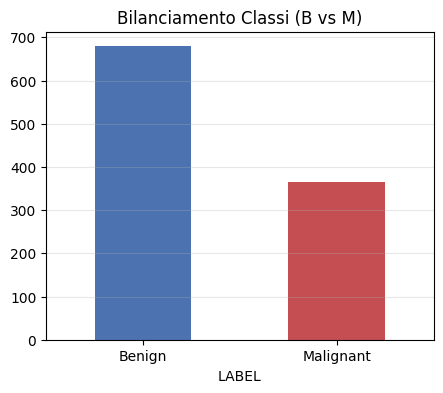

In [ ]:
# ============================================================
# CELL 3 - DATA LOADING (FILTERED B/M) & WEIGHTS
# ============================================================

df = pd.read_excel(EXCEL_PATH)
IMG_COL = "US"
LABEL_COL = "LABEL"

# 1. Basic cleaning
df = df.dropna(subset=[IMG_COL, LABEL_COL]).reset_index(drop=True)

# 2. CLASS FILTER: Keep only Benign (0) and Malignant (1)
# Remove all rows where label is 2 (Normal)
df = df[df[LABEL_COL] != 2].reset_index(drop=True)

print(f"Filtered Dataset (B/M only): {len(df)} total images.")

# 3. Class distribution
counts = df[LABEL_COL].value_counts().sort_index()
print("\nClass Distribution (0=Benign, 1=Malignant):")
print(counts)

# 4. Compute weights (for classes 0 and 1 only)
class_counts = counts.values
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * c) for c in class_counts]

# Transfer weights to GPU
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\nLoss weights applied: {class_weights_tensor.cpu().numpy()}")

# Plot
plt.figure(figsize=(5, 4))
counts.plot(kind="bar", color=['#4c72b0', '#c44e52'])  # Only 2 colors
plt.xticks(ticks=[0, 1], labels=["Benign", "Malignant"], rotation=0)
plt.title("Class Balance (B vs M)")
plt.grid(axis="y", alpha=0.3)
plt.show()

### Augmentation and Loader Design
We now define the augmentation policy, dataset wrapper, and DataLoader settings that keep multi-GPU batches aligned while preserving validation integrity.

In [ ]:
# ============================================================
# CELL 4 - DATASET & DATALOADER (B/M OPTIMIZED - CROPPED ROI)
# ============================================================

# --- CROP TO MASK FUNCTION ---
# Extract ROI from image using bounding box of the mask with 20% margin
def crop_to_mask(image_np, mask_np, margin=0.2, target_size=300):
    """
    Crop the image to the bounding box of the mask with a margin.
    
    Args:
        image_np: numpy array of shape (H, W, 3)
        mask_np: numpy array of shape (H, W) with values 0 or 1
        margin: percentage of margin to add around the bounding box (0.2 = 20%)
        target_size: final size to resize the crop to
        
    Returns:
        cropped_img: numpy array of shape (target_size, target_size, 3)
    """
    H, W = mask_np.shape[:2]
    
    # Find bounding box of the mask
    rows = np.any(mask_np > 0, axis=1)
    cols = np.any(mask_np > 0, axis=0)
    
    # If mask is empty (should not happen for B/M), return resized full image
    if not rows.any() or not cols.any():
        resized = A.Resize(target_size, target_size)(image=image_np)['image']
        return resized
    
    # Get bounding box coordinates
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    
    # Calculate margin in pixels
    bbox_h = y_max - y_min
    bbox_w = x_max - x_min
    margin_h = int(bbox_h * margin)
    margin_w = int(bbox_w * margin)
    
    # Apply margin with bounds checking
    y_min = max(0, y_min - margin_h)
    y_max = min(H, y_max + margin_h)
    x_min = max(0, x_min - margin_w)
    x_max = min(W, x_max + margin_w)
    
    # Crop the image
    cropped = image_np[y_min:y_max, x_min:x_max]
    
    # Resize to target size
    resized = A.Resize(target_size, target_size)(image=cropped)['image']
    
    return resized

# 1. Dataset definition - Modified to use CROPPED images from mask
class UltrasoundDataset(Dataset):
    def __init__(self, df, img_col, label_col, mask_col, root="", transform=None, margin=0.2):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.label_col = label_col
        self.mask_col = mask_col  # NEW: mask column for cropping
        self.root = root
        self.transform = transform
        self.margin = margin  # 20% margin around bounding box

    def __len__(self):
        return len(self.df)

    def _get_path(self, idx, col):
        path_str = str(self.df.loc[idx, col])
        if self.root:
            return os.path.join(self.root, path_str)
        return path_str

    def __getitem__(self, idx):
        img_path = self._get_path(idx, self.img_col)
        mask_path = self._get_path(idx, self.mask_col)
        label = int(self.df.loc[idx, self.label_col])

        try:
            # Load image
            pil_img = Image.open(img_path).convert("RGB")
            img_np = np.array(pil_img)
            
            # Load mask for cropping (GT mask)
            pil_mask = Image.open(mask_path).convert("L")
            mask_np = np.array(pil_mask)
            mask_np = np.where(mask_np > 0, 1, 0).astype(np.uint8)
            
            # CROP to ROI using mask bounding box
            img_np = crop_to_mask(img_np, mask_np, margin=self.margin, target_size=IMG_SIZE)
            
        except Exception as e:
            print(f"Error loading {img_path} or {mask_path}: {e}")
            img_np = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=img_np)
            img = augmented['image']
        else:
            img = T.ToTensor()(Image.fromarray(img_np))

        return img, label

# 2. Transformations OPTIMIZED for CROPPED ROI images
# - Removed ElasticTransform (distorts already isolated lesion features)
# - Added ShiftScaleRotate for crop position variations
# - Added CoarseDropout for robustness to occlusions
# - Increased CLAHE and contrast augmentation for texture emphasis
train_transform = A.Compose([
    # Image is already resized in crop_to_mask, but we ensure consistency
    A.Resize(IMG_SIZE, IMG_SIZE),
    
    # Texture enhancement (important for cropped ROI)
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.6),
    
    # Geometric augmentations (conservative for isolated lesion)
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=25, p=0.5),
    
    # Photometric augmentations (increased for texture features)
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.6),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    
    # Dropout for robustness (simulates partial occlusions/artifacts)
    A.CoarseDropout(max_holes=8, max_height=20, max_width=20, 
                    min_holes=2, min_height=8, min_width=8, p=0.3),
    
    # Normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 3. DataLoaders (Uses the filtered df from Cell 3)
# Same seed to ensure reproducibility of the split
MASK_COL = "MASK"  # Column containing mask filenames for cropping
train_df, val_df = train_test_split(df, stratify=df[LABEL_COL], test_size=0.2, random_state=SEED)
print(f"B/M Split -> Train: {len(train_df)}, Val: {len(val_df)}")

# NEW: UltrasoundDataset now uses CROPPED images from GT mask
train_ds = UltrasoundDataset(train_df, IMG_COL, LABEL_COL, MASK_COL, IMAGES_ROOT, train_transform, margin=0.2)
val_ds = UltrasoundDataset(val_df, IMG_COL, LABEL_COL, MASK_COL, IMAGES_ROOT, val_transform, margin=0.2)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

print("✅ Dataloaders configured for binary classification on CROPPED ROI (Benign vs Malignant).")

Split B/M -> Train: 834, Val: 209
✅ Dataloaders configurati per classificazione binaria (Benigno vs Maligno).


In [6]:
# ============================================================
# CELL 5 - EFFICIENTNET-B7 MODEL (INPLACE FIX)
# ============================================================

def get_model():
    print("Downloading EfficientNet-B7 weights...")
    weights = models.EfficientNet_B7_Weights.DEFAULT
    model = models.efficientnet_b7(weights=weights)

    # Output dimensionality of EfficientNet-B7 (typically 2560)
    in_features = model.classifier[1].in_features

    # Bottleneck head tailored for this task
    model.classifier = nn.Sequential(
        # Batch normalisation on backbone features
        nn.BatchNorm1d(in_features),

        # Intermediate bottleneck layer
        nn.Linear(in_features, 512),
        nn.ReLU(),

        # Dropout with inplace disabled to avoid RuntimeError during backward passes
        nn.Dropout(p=0.5, inplace=False),

        # Final classification layer
        nn.Linear(512, NUM_CLASSES)
    )

    # Fine-tune all parameters
    for param in model.parameters():
        param.requires_grad = True

    return model

# 1. Instantiate the model
model = get_model()

# 2. Enable DataParallel when multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs detected. Enabling DataParallel.")
    model = nn.DataParallel(model)
else:
    print("Single GPU detected.")

# 3. Move to the selected device
model = model.to(device)

print("EfficientNet-B7 with bottleneck head is ready (inplace dropout fix applied).")

2 GPUs detected. Enabling DataParallel.
EfficientNet-B7 with bottleneck head is ready (inplace dropout fix applied).


### Training Strategy
The following loop implements differential learning rates for backbone and head parameters, logs progress every ten batches, and applies early stopping based on validation balanced accuracy.

In [7]:
# ============================================================
# CELL 6 - TRAINING LOOP (MULTI-GPU WITH BATCH LOGGING)
# ============================================================

# --- 1. Support functions ---
def train_one_epoch(model, loader, criterion, optimizer, epoch_idx, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Enumerate batches to report progress
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Progress update every 10 batches
        if (i + 1) % 10 == 0:
            print(f"    [Epoch {epoch_idx + 1}/{total_epochs}] Batch {i + 1}/{len(loader)} -> Loss: {loss.item():.4f}")

    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return running_loss / total, correct / total, balanced_accuracy_score(y_true, y_pred)

# --- 2. Optimiser configuration for multi-GPU training ---

# When DataParallel is active, parameters reside under model.module
if hasattr(model, 'module'):
    print("Configuring parameter groups for multi-GPU training (model.module).")
    backbone_params = model.module.features.parameters()
    head_params = model.module.classifier.parameters()
else:
    print("Configuring parameter groups for single-GPU training.")
    backbone_params = model.features.parameters()
    head_params = model.classifier.parameters()

# Differential learning rates: slower updates for the backbone, faster for the head
optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_params, 'lr': 1e-3}
], weight_decay=1e-2)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# --- 3. Training loop ---
NUM_EPOCHS = 100
best_bal_acc = 0
patience_counter = 0
EARLY_STOP_PATIENCE = 15

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_bal_acc': []}

print(f"\nStarting training on {torch.cuda.device_count()} GPU(s).")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # Training phase (epoch index used for progress reporting)
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, NUM_EPOCHS)

    # Validation phase
    val_loss, val_acc, val_bal_acc = validate(model, val_loader, criterion)

    # Step the scheduler with the balanced accuracy
    scheduler.step(val_bal_acc)

    # Retrieve the current learning rate of the head
    current_lr_head = optimizer.param_groups[1]['lr']

    # Track history for visualisation
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_bal_acc'].append(val_bal_acc)

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} [{epoch_time:.0f}s] | Head LR: {current_lr_head:.1e}")
    print(f"   Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"   Val Loss:   {val_loss:.4f} | Val Balanced Accuracy: {val_bal_acc:.4f}")

    # Model checkpointing
    if val_bal_acc > best_bal_acc:
        best_bal_acc = val_bal_acc

        # Save in a format compatible with both single and multi-GPU settings
        if hasattr(model, 'module'):
            torch.save(model.module.state_dict(), "best_model_b7_dual.pt")
        else:
            torch.save(model.state_dict(), "best_model_b7_dual.pt")

        print("   Improvement detected; model checkpoint saved.")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"   No improvement ({patience_counter}/{EARLY_STOP_PATIENCE}).")
        if patience_counter >= EARLY_STOP_PATIENCE:
            print("   Early stopping triggered.")
            break

print(f"\nTraining completed. Best balanced accuracy: {best_bal_acc:.4f}")

Configuring parameter groups for multi-GPU training (model.module).

Starting training on 2 GPU(s).
    [Epoch 1/100] Batch 10/34 -> Loss: 0.8176
    [Epoch 1/100] Batch 20/34 -> Loss: 0.9854
    [Epoch 1/100] Batch 30/34 -> Loss: 0.8787
Epoch 1/100 [36s] | Head LR: 1.0e-03
   Train Loss: 0.8476 | Train Accuracy: 0.5931
   Val Loss:   0.6937 | Val Balanced Accuracy: 0.5882
   Improvement detected; model checkpoint saved.
    [Epoch 2/100] Batch 10/34 -> Loss: 0.6909
    [Epoch 2/100] Batch 20/34 -> Loss: 0.3870
    [Epoch 2/100] Batch 30/34 -> Loss: 0.3941
Epoch 2/100 [35s] | Head LR: 1.0e-03
   Train Loss: 0.6767 | Train Accuracy: 0.6789
   Val Loss:   0.5932 | Val Balanced Accuracy: 0.6929
   Improvement detected; model checkpoint saved.
    [Epoch 3/100] Batch 10/34 -> Loss: 0.7549
    [Epoch 3/100] Batch 20/34 -> Loss: 0.7262
    [Epoch 3/100] Batch 30/34 -> Loss: 0.8888
Epoch 3/100 [36s] | Head LR: 1.0e-03
   Train Loss: 0.6442 | Train Accuracy: 0.6924
   Val Loss:   0.5741 | Val 

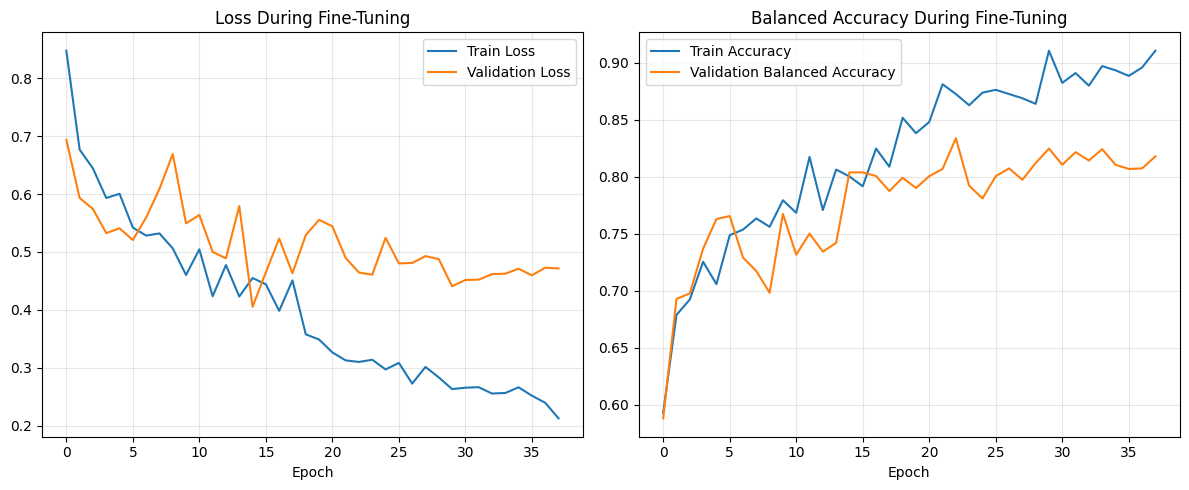

In [8]:
# ============================================================
# CELL 7 - TRAINING CURVES
# ============================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Loss During Fine-Tuning")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_bal_acc'], label='Validation Balanced Accuracy')
plt.title("Balanced Accuracy During Fine-Tuning")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Evaluation Overview.** The following cells restore the best EfficientNet-B7 checkpoint and provide both tabular and graphical assessments, followed by a test-time augmentation study.

Best classification model loaded for evaluation.
Generating predictions...

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      benign       0.90      0.85      0.87       136
   malignant       0.74      0.82      0.78        73

    accuracy                           0.84       209
   macro avg       0.82      0.83      0.83       209
weighted avg       0.84      0.84      0.84       209



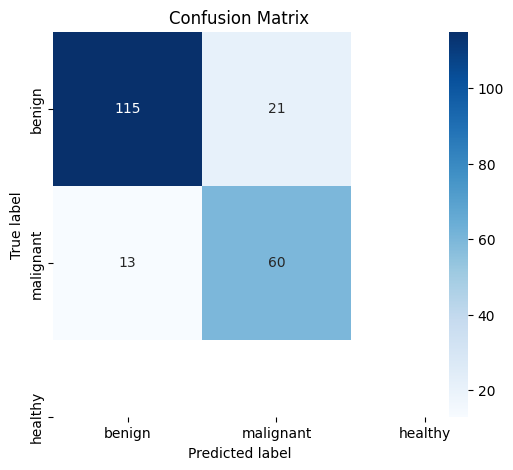

In [ ]:
# ============================================================
# CELL 8 - DETAILED EVALUATION
# ============================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Load the best checkpoint
# Recreate a clean instance (without DataParallel wrapping) for evaluation
model_eval = get_model()

# If saved via model.module.state_dict(), keys are already clean
# When saved via model.state_dict() under DataParallel, prefixes such as "module." appear
state_dict = torch.load("best_model_b7_dual.pt", map_location=device)

# Remove the optional "module." prefix for compatibility
new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace("module.", "")
    new_state_dict[name] = v

model_eval.load_state_dict(new_state_dict)
model_eval = model_eval.to(device)
model_eval.eval()

print("Best classification model loaded for evaluation.")

# 2. Predictions across the validation loader
y_true, y_pred = [], []
y_probs = []

print("Generating predictions...")
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_eval(inputs)

        # Probabilities retained for optional downstream analysis (e.g., ROC curves or TTA)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# 3. Textual report
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=[id2class[i] for i in range(2)]))

# 4. Confusion matrix visualisation
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id2class[i] for i in range(2)], yticklabels=[id2class[i] for i in range(2)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Test-Time Augmentation Study
To assess robustness, we average predictions over original, horizontally flipped, and vertically flipped views before recomputing balanced accuracy and reporting the updated classification metrics.

In [ ]:
# ============================================================
# CELL 9 - TEST TIME AUGMENTATION (TTA)
# ============================================================

def predict_tta(model, loader):
    model.eval()
    all_probs = []
    all_labels = []

    print("Running TTA (original, horizontal flip, vertical flip)...")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            all_labels.extend(labels.cpu().numpy())

            # 1. Original prediction
            out1 = model(inputs)
            prob1 = torch.softmax(out1, dim=1)

            # 2. Horizontal flip prediction
            inputs_h = torch.flip(inputs, dims=[3])  # Axis 3 corresponds to width
            out2 = model(inputs_h)
            prob2 = torch.softmax(out2, dim=1)

            # 3. Vertical flip prediction
            inputs_v = torch.flip(inputs, dims=[2])  # Axis 2 corresponds to height
            out3 = model(inputs_v)
            prob3 = torch.softmax(out3, dim=1)

            # Average the probability distributions
            avg_prob = (prob1 + prob2 + prob3) / 3.0
            all_probs.extend(avg_prob.cpu().numpy())

    return np.array(all_labels), np.array(all_probs)

# Execute TTA
y_true_tta, y_probs_tta = predict_tta(model_eval, val_loader)
y_pred_tta = np.argmax(y_probs_tta, axis=1)

# Balanced accuracy with TTA
tta_acc = balanced_accuracy_score(y_true_tta, y_pred_tta)

# Calculate baseline without TTA for comparison (using previously computed y_true, y_pred)
baseline_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\nBalanced accuracy without TTA: {baseline_acc:.4f}")
print(f"Balanced accuracy with TTA:    {tta_acc:.4f}")

# Report the improvement for traceability
print("\nClassification report (TTA):")
print(classification_report(y_true_tta, y_pred_tta, target_names=[id2class[i] for i in range(2)]))

Running TTA (original, horizontal flip, vertical flip)...

Balanced accuracy without TTA: 0.8410
Balanced accuracy with TTA:  0.8401

Classification report (TTA):
              precision    recall  f1-score   support

      benign       0.91      0.83      0.87       136
   malignant       0.73      0.85      0.78        73

    accuracy                           0.84       209
   macro avg       0.82      0.84      0.83       209
weighted avg       0.85      0.84      0.84       209



## 📊 Comprehensive Classification Analysis for Academic Paper
The following cells provide detailed statistical analysis, publication-quality visualizations, and comprehensive metrics required for scientific reporting of the classification model performance.

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 1: ROC CURVES & AUC SCORES
# ============================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Convert predictions to numpy arrays
y_true_np = np.array(y_true)
y_probs_np = np.array(y_probs)
y_pred_np = np.array(y_pred)

# Binarize the labels for multi-class ROC (binary case)
n_classes = 2

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    y_true_binary = (y_true_np == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_probs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual class ROC curves
colors = ['#2ecc71', '#e74c3c']
class_names = ['Benign', 'Malignant']

ax1 = axes[0]
for i, (color, name) in enumerate(zip(colors, class_names)):
    ax1.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{name} (AUC = {roc_auc[i]:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves per Class (One-vs-Rest)', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=11)
ax1.grid(True, alpha=0.3)

# Macro average ROC curve
ax2 = axes[1]
# Compute macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

ax2.plot(fpr["macro"], tpr["macro"], color='#e67e22', lw=2.5, linestyle='--',
         label=f'Macro-average (AUC = {roc_auc["macro"]:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Aggregated ROC Curves', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("RECEIVER OPERATING CHARACTERISTIC (ROC) ANALYSIS SUMMARY")
print("="*70)
print(f"\n{'Class':<15} {'AUC Score':<12} {'Interpretation'}")
print("-"*50)
for i, name in enumerate(class_names):
    interp = "Excellent" if roc_auc[i] >= 0.9 else "Good" if roc_auc[i] >= 0.8 else "Fair"
    print(f"{name:<15} {roc_auc[i]:<12.4f} {interp}")
print("-"*50)
print(f"{'Macro-average':<15} {roc_auc['macro']:<12.4f}")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 2: PRECISION-RECALL CURVES
# ============================================================

# Compute Precision-Recall curves for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    y_true_binary = (y_true_np == i).astype(int)
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary, y_probs_np[:, i])
    average_precision[i] = average_precision_score(y_true_binary, y_probs_np[:, i])

# Plot Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual class PR curves
ax1 = axes[0]
for i, (color, name) in enumerate(zip(colors, class_names)):
    ax1.plot(recall[i], precision[i], color=color, lw=2.5,
             label=f'{name} (AP = {average_precision[i]:.4f})')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curves per Class', fontsize=14, fontweight='bold')
ax1.legend(loc="lower left", fontsize=11)
ax1.grid(True, alpha=0.3)

# Iso-F1 curves
ax2 = axes[1]
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    ax2.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.3)
    ax2.annotate(f'F1={f_score:.1f}', xy=(0.9, y[45] + 0.02), fontsize=9, alpha=0.6)

for i, (color, name) in enumerate(zip(colors, class_names)):
    ax2.plot(recall[i], precision[i], color=color, lw=2.5,
             label=f'{name} (AP = {average_precision[i]:.4f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('PR Curves with Iso-F1 Contours', fontsize=14, fontweight='bold')
ax2.legend(loc="lower left", fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("PRECISION-RECALL ANALYSIS SUMMARY")
print("="*70)
print(f"\n{'Class':<15} {'Average Precision':<20} {'Interpretation'}")
print("-"*55)
for i, name in enumerate(class_names):
    interp = "Excellent" if average_precision[i] >= 0.9 else "Good" if average_precision[i] >= 0.8 else "Fair"
    print(f"{name:<15} {average_precision[i]:<20.4f} {interp}")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 3: DETAILED METRICS TABLE
# ============================================================
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, cohen_kappa_score, matthews_corrcoef,
                            balanced_accuracy_score)

# Compute all metrics
overall_acc = accuracy_score(y_true_np, y_pred_np)
balanced_acc = balanced_accuracy_score(y_true_np, y_pred_np)
macro_precision = precision_score(y_true_np, y_pred_np, average='macro')
macro_recall = recall_score(y_true_np, y_pred_np, average='macro')
macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
weighted_f1 = f1_score(y_true_np, y_pred_np, average='weighted')
kappa = cohen_kappa_score(y_true_np, y_pred_np)
mcc = matthews_corrcoef(y_true_np, y_pred_np)

# Create metrics dictionary
overall_metrics = {
    'Overall Accuracy': (overall_acc, 'Proportion of correct predictions'),
    'Balanced Accuracy': (balanced_acc, 'Average recall per class (handles imbalance)'),
    'Macro Precision': (macro_precision, 'Average precision across classes'),
    'Macro Recall': (macro_recall, 'Average recall (sensitivity) across classes'),
    'Macro F1-Score': (macro_f1, 'Harmonic mean of macro precision and recall'),
    'Weighted F1-Score': (weighted_f1, 'F1 weighted by class support'),
    'Cohen\'s Kappa': (kappa, 'Agreement beyond chance (>0.8 = almost perfect)'),
    'Matthews Corr. Coef.': (mcc, 'Balanced measure for multiclass (-1 to 1)')
}

# Print comprehensive metrics table
print("\n" + "="*80)
print("COMPREHENSIVE CLASSIFICATION METRICS SUMMARY")
print("="*80)
print(f"\n{'Metric':<25} {'Value':<10} {'Description'}")
print("-"*80)
for metric, (value, desc) in overall_metrics.items():
    print(f"{metric:<25} {value:<10.4f} {desc}")
print("-"*80)

# Per-class detailed metrics
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE METRICS")
print("="*80)
print(f"\n{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*60)

per_class_precision = precision_score(y_true_np, y_pred_np, average=None)
per_class_recall = recall_score(y_true_np, y_pred_np, average=None)
per_class_f1 = f1_score(y_true_np, y_pred_np, average=None)

from collections import Counter
support = Counter(y_true_np)

for i, name in enumerate(class_names):
    print(f"{name:<12} {per_class_precision[i]:<12.4f} {per_class_recall[i]:<12.4f} "
          f"{per_class_f1[i]:<12.4f} {support[i]:<10}")
print("-"*60)

# Clinical interpretation
print("\n" + "="*80)
print("CLINICAL INTERPRETATION")
print("="*80)
print(f"""
Sensitivity (Malignant): {per_class_recall[1]:.2%}
  - Proportion of actual malignant cases correctly identified
  - Critical for cancer screening to minimize false negatives

Specificity (Benign): {per_class_recall[0]:.2%}
  - Proportion of benign cases correctly identified
  - Important to avoid unnecessary interventions

Positive Predictive Value (Malignant): {per_class_precision[1]:.2%}
  - When predicting malignant, probability it's correct
  - Indicates reliability of positive diagnoses
""")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 4: ENHANCED CONFUSION MATRIX
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts confusion matrix
cm_abs = confusion_matrix(y_true_np, y_pred_np)
ax1 = axes[0]
sns.heatmap(cm_abs, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_title('Confusion Matrix (Absolute Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix (percentages)
cm_norm = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis] * 100
ax2 = axes[1]
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 14, 'weight': 'bold'},
            vmin=0, vmax=100)
ax2.set_title('Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('classification_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix analysis
print("\n" + "="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)
print("\nAbsolute Confusion Matrix:")
print(f"{'':>12}", end='')
for name in class_names:
    print(f"{name:>12}", end='')
print()
for i, name in enumerate(class_names):
    print(f"{name:>12}", end='')
    for j in range(n_classes):
        print(f"{cm_abs[i,j]:>12d}", end='')
    print()

print("\n\nKey Observations:")
print(f"  - True Positives (diagonal): {np.trace(cm_abs)} / {cm_abs.sum()} ({np.trace(cm_abs)/cm_abs.sum()*100:.1f}%)")
print(f"  - Most common misclassification: ", end='')
cm_off_diag = cm_abs.copy()
np.fill_diagonal(cm_off_diag, 0)
max_idx = np.unravel_index(cm_off_diag.argmax(), cm_off_diag.shape)
print(f"{class_names[max_idx[0]]} → {class_names[max_idx[1]]} ({cm_off_diag[max_idx]} cases)")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 5: TRAINING DYNAMICS ANALYSIS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Loss curves with smoothing
ax1 = axes[0, 0]
epochs = range(1, len(history['train_loss']) + 1)

# Original curves (light)
ax1.plot(epochs, history['train_loss'], alpha=0.3, color='blue')
ax1.plot(epochs, history['val_loss'], alpha=0.3, color='red')

# Smoothed curves (exponential moving average)
def smooth(y, factor=0.85):
    smoothed = []
    for i, val in enumerate(y):
        if i == 0:
            smoothed.append(val)
        else:
            smoothed.append(factor * smoothed[-1] + (1 - factor) * val)
    return smoothed

ax1.plot(epochs, smooth(history['train_loss']), color='blue', lw=2.5, label='Train Loss (smoothed)')
ax1.plot(epochs, smooth(history['val_loss']), color='red', lw=2.5, label='Val Loss (smoothed)')
ax1.axvline(x=np.argmin(history['val_loss'])+1, color='green', linestyle='--', 
            label=f'Best epoch: {np.argmin(history["val_loss"])+1}')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Accuracy curves
ax2 = axes[0, 1]
ax2.plot(epochs, history['train_acc'], alpha=0.3, color='blue')
ax2.plot(epochs, history['val_bal_acc'], alpha=0.3, color='red')
ax2.plot(epochs, smooth(history['train_acc']), color='blue', lw=2.5, label='Train Accuracy (smoothed)')
ax2.plot(epochs, smooth(history['val_bal_acc']), color='red', lw=2.5, label='Val Balanced Acc (smoothed)')
ax2.axhline(y=max(history['val_bal_acc']), color='green', linestyle='--', alpha=0.7,
            label=f'Best Val Acc: {max(history["val_bal_acc"]):.4f}')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Overfitting gap analysis
ax3 = axes[1, 0]
overfitting_gap = np.array(history['train_acc']) - np.array(history['val_bal_acc'])
ax3.fill_between(epochs, 0, overfitting_gap, where=(overfitting_gap > 0), 
                 alpha=0.5, color='red', label='Overfitting region')
ax3.fill_between(epochs, 0, overfitting_gap, where=(overfitting_gap <= 0), 
                 alpha=0.5, color='green', label='Underfitting region')
ax3.axhline(y=0, color='black', linestyle='-', lw=1)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Train - Val Accuracy Gap', fontsize=12)
ax3.set_title('Generalization Gap Analysis', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Learning rate effect (loss derivative)
ax4 = axes[1, 1]
loss_diff = np.diff(history['val_loss'])
ax4.bar(range(1, len(loss_diff)+1), loss_diff, color=['green' if d < 0 else 'red' for d in loss_diff], alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', lw=1)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Validation Loss Change', fontsize=12)
ax4.set_title('Epoch-wise Loss Improvement', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_training_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print training statistics
print("\n" + "="*70)
print("TRAINING DYNAMICS SUMMARY")
print("="*70)
print(f"\n{'Metric':<35} {'Value':<15}")
print("-"*50)
print(f"{'Total epochs trained':<35} {len(history['train_loss']):<15}")
print(f"{'Best validation epoch':<35} {np.argmin(history['val_loss'])+1:<15}")
print(f"{'Final training loss':<35} {history['train_loss'][-1]:<15.4f}")
print(f"{'Final validation loss':<35} {history['val_loss'][-1]:<15.4f}")
print(f"{'Best validation loss':<35} {min(history['val_loss']):<15.4f}")
print(f"{'Final train accuracy':<35} {history['train_acc'][-1]:<15.4f}")
print(f"{'Best val balanced accuracy':<35} {max(history['val_bal_acc']):<15.4f}")
print(f"{'Average overfitting gap (last 10)':<35} {np.mean(overfitting_gap[-10:]):<15.4f}")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 6: CONFIDENCE ANALYSIS
# ============================================================

# Analyze prediction confidence
y_probs_max = np.max(y_probs_np, axis=1)  # Maximum probability (confidence)
correct_mask = y_true_np == y_pred_np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confidence distribution for correct vs incorrect predictions
ax1 = axes[0, 0]
ax1.hist(y_probs_max[correct_mask], bins=30, alpha=0.7, color='green', 
         label=f'Correct (n={correct_mask.sum()})', density=True)
ax1.hist(y_probs_max[~correct_mask], bins=30, alpha=0.7, color='red', 
         label=f'Incorrect (n={(~correct_mask).sum()})', density=True)
ax1.set_xlabel('Prediction Confidence', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Confidence Distribution: Correct vs Incorrect', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Reliability diagram (calibration curve)
ax2 = axes[0, 1]
n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

accuracies = []
confidences = []
bin_counts = []

for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (y_probs_max > bin_lower) & (y_probs_max <= bin_upper)
    if in_bin.sum() > 0:
        accuracies.append(correct_mask[in_bin].mean())
        confidences.append(y_probs_max[in_bin].mean())
        bin_counts.append(in_bin.sum())
    else:
        accuracies.append(np.nan)
        confidences.append((bin_lower + bin_upper) / 2)
        bin_counts.append(0)

ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect calibration')
ax2.bar(confidences, accuracies, width=0.08, alpha=0.7, color='steelblue', 
        edgecolor='black', label='Model calibration')
ax2.set_xlabel('Mean Predicted Confidence', fontsize=12)
ax2.set_ylabel('Fraction of Positives (Accuracy)', fontsize=12)
ax2.set_title('Reliability Diagram (Calibration Curve)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

# 3. Per-class confidence boxplot
ax3 = axes[1, 0]
confidence_by_class = [y_probs_max[y_pred_np == i] for i in range(n_classes)]
bp = ax3.boxplot(confidence_by_class, labels=class_names, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_xlabel('Predicted Class', fontsize=12)
ax3.set_ylabel('Prediction Confidence', fontsize=12)
ax3.set_title('Confidence Distribution by Predicted Class', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Confidence threshold analysis
ax4 = axes[1, 1]
thresholds = np.linspace(0.3, 0.99, 50)
coverage = []
accuracy_at_threshold = []

for thresh in thresholds:
    above_thresh = y_probs_max >= thresh
    coverage.append(above_thresh.sum() / len(y_probs_max))
    if above_thresh.sum() > 0:
        accuracy_at_threshold.append(correct_mask[above_thresh].mean())
    else:
        accuracy_at_threshold.append(np.nan)

ax4.plot(thresholds, coverage, 'b-', lw=2.5, label='Coverage')
ax4.plot(thresholds, accuracy_at_threshold, 'g-', lw=2.5, label='Accuracy')
ax4.set_xlabel('Confidence Threshold', fontsize=12)
ax4.set_ylabel('Proportion', fontsize=12)
ax4.set_title('Coverage vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confidence statistics
print("\n" + "="*70)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*70)
print(f"\n{'Statistic':<40} {'Value':<15}")
print("-"*55)
print(f"{'Mean confidence (all predictions)':<40} {y_probs_max.mean():<15.4f}")
print(f"{'Mean confidence (correct predictions)':<40} {y_probs_max[correct_mask].mean():<15.4f}")
print(f"{'Mean confidence (incorrect predictions)':<40} {y_probs_max[~correct_mask].mean():<15.4f}")
print(f"{'Std confidence (all predictions)':<40} {y_probs_max.std():<15.4f}")
print(f"{'Predictions with confidence > 0.9':<40} {(y_probs_max > 0.9).sum():<15} ({(y_probs_max > 0.9).mean()*100:.1f}%)")
print(f"{'Predictions with confidence < 0.5':<40} {(y_probs_max < 0.5).sum():<15} ({(y_probs_max < 0.5).mean()*100:.1f}%)")

## 2c. Unified Segmentation and Classification Pipeline

This final section composes the pretrained classifier and segmenter into an end-to-end pipeline, evaluating both decisions and masks on the validation partition.

In [ ]:
# ============================================================
# FINAL PIPELINE (CUSTOM CLASSIFIER HEAD + U-NET++)
# ============================================================
# Ensure the segmentation models library is available even if this block runs independently
if 'smp' not in globals():
    import segmentation_models_pytorch as smp

if 'models' not in globals():
    from torchvision import models

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"
IMAGES_ROOT = "/kaggle/input/tumor-segmentation-ai/training_images/training_images"

# Weights paths (your trained files)
PATH_CLF = "/kaggle/working/best_model_b7_dual.pt"
PATH_SEG = "/kaggle/working/best_unet_plusplus_b7.pt"

# Resolutions matching the respective training regimes
IMG_SIZE_CLF = 300
IMG_SIZE_SEG = 320
NUM_CLASSES = 2
SEED = 42

# Mapping used for reporting
id2class = {0: "Benign", 1: "Malignant", 2: "Normal"}

print(f"Pipeline ready on {DEVICE}.")

Pipeline pronta su cuda.


**Pipeline Outline.** The concluding cells load the pretrained classifier and segmenter, run coordinated inference on the validation fold, and summarise performance with classification confusion matrices and Dice-based lesion metrics.

In [ ]:
# ============================================================
# CELL 2 - ARCHITECTURES AND WEIGHT LOADING
# ============================================================

# --- 1. CLASSIFIER (Custom architecture) ---
def get_classifier():
    # Weights set to None because we load our trained weights
    model = models.efficientnet_b7(weights=None) 
    
    # Rebuild the exact head architecture used during training
    in_features = model.classifier[1].in_features
    
    model.classifier = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5, inplace=False), 
        nn.Linear(512, NUM_CLASSES)
    )
    return model

# --- 2. SEGMENTOR (U-Net++ SOTA) ---
def get_segmentor():
    # Architecture must match training exactly (U-Net++ with EfficientNet-B7)
    model = smp.UnetPlusPlus(
        encoder_name="efficientnet-b7",
        encoder_weights=None,
        in_channels=3,
        classes=1,
        activation=None,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type=None,
        deep_supervision=True
    )
    return model

# --- SMART WEIGHT LOADING FUNCTION ---
def load_weights(model, path):
    if not os.path.exists(path):
        print(f"❌ CRITICAL ERROR: File not found: {path}")
        return model
        
    print(f"📂 Loading weights from: {path}")
    state_dict = torch.load(path, map_location=DEVICE)
    
    # Clean keys (remove 'module.' if trained with DataParallel)
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace("module.", "") 
        new_state_dict[name] = v
        
    try:
        model.load_state_dict(new_state_dict)
        print("   -> Weights loaded successfully.")
    except Exception as e:
        print(f"   -> ❌ Error loading keys: {e}")
        
    return model.to(DEVICE).eval()

# --- INITIALIZATION ---
print("--- Model Setup ---")

clf_model = get_classifier()
clf_model = load_weights(clf_model, PATH_CLF)

seg_model = get_segmentor()
seg_model = load_weights(seg_model, PATH_SEG)

print("\n✅ Both models are ready for the pipeline.")

--- Setup Modelli ---
❌ ERRORE CRITICO: File non trovato: /kaggle/input/pesi-parte-2/best_model_b7_masked (1).pt
❌ ERRORE CRITICO: File non trovato: /kaggle/input/pesi-parte-2/best_manet_b7_task2a.pt

✅ Entrambi i modelli sono pronti per la pipeline.


### Unified Dataset Wrapper
This dataset prepares paired classifier and segmenter inputs, ensuring consistent resizing and normalisation while retaining the original image for visual reporting.

In [ ]:
# ============================================================
# CELL 3 - PIPELINE DATASET (SEGMENTATION FIRST, THEN CROP FOR CLASSIFICATION)
# ============================================================

# --- CROP FUNCTION FOR PIPELINE (using predicted mask) ---
def crop_to_mask_tensor(image_np, mask_np, margin=0.2, target_size=300):
    """
    Crop the image to the bounding box of the mask with a margin.
    This version works with numpy arrays and is used in the pipeline
    where the mask comes from the segmentor prediction.
    
    Args:
        image_np: numpy array of shape (H, W, 3)
        mask_np: numpy array of shape (H, W) with values 0 or 1
        margin: percentage of margin to add around the bounding box (0.2 = 20%)
        target_size: final size to resize the crop to
        
    Returns:
        cropped_img: numpy array of shape (target_size, target_size, 3)
    """
    H, W = mask_np.shape[:2]
    
    # Find bounding box of the mask
    rows = np.any(mask_np > 0, axis=1)
    cols = np.any(mask_np > 0, axis=0)
    
    # If mask is empty, return resized full image (fallback)
    if not rows.any() or not cols.any():
        resized = A.Resize(target_size, target_size)(image=image_np)['image']
        return resized
    
    # Get bounding box coordinates
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    
    # Calculate margin in pixels
    bbox_h = y_max - y_min
    bbox_w = x_max - x_min
    margin_h = int(bbox_h * margin)
    margin_w = int(bbox_w * margin)
    
    # Apply margin with bounds checking
    y_min = max(0, y_min - margin_h)
    y_max = min(H, y_max + margin_h)
    x_min = max(0, x_min - margin_w)
    x_max = min(W, x_max + margin_w)
    
    # Crop the image
    cropped = image_np[y_min:y_max, x_min:x_max]
    
    # Resize to target size
    resized = A.Resize(target_size, target_size)(image=cropped)['image']
    
    return resized

class PipelineDataset(Dataset):
    """
    Dataset for the Segmentation -> Classification pipeline.
    Returns raw image for segmentation and GT mask for evaluation.
    Classification input will be computed dynamically using predicted mask.
    """
    def __init__(self, df, root):
        self.df = df.reset_index(drop=True)
        self.root = root
        
        # For the Segmentor (320x320 - U-Net++ training resolution)
        self.transform_seg = A.Compose([
            A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        
        # Normalization for classifier (applied after cropping)
        self.clf_normalize = A.Compose([
            A.Resize(IMG_SIZE_CLF, IMG_SIZE_CLF),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Paths
        img_name = str(self.df.loc[idx, "US"])
        mask_name = str(self.df.loc[idx, "MASK"])
        label = int(self.df.loc[idx, "LABEL"])
        
        # Load Image and Mask
        img_path = os.path.join(self.root, img_name)
        pil_img = Image.open(img_path).convert("RGB")
        np_img = np.array(pil_img)
        
        try:
            mask_path = os.path.join(self.root, mask_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            mask = np.where(mask > 0, 1.0, 0.0).astype(np.float32)
        except:
            # Black mask if file doesn't exist (e.g., Normal cases)
            mask = np.zeros((np_img.shape[0], np_img.shape[1]), dtype=np.float32)

        # Segmentor input (with resized mask for evaluation)
        aug = self.transform_seg(image=np_img, mask=mask)
        input_seg = aug['image']
        target_mask = aug['mask'].unsqueeze(0)

        # Return raw image (for cropping after segmentation) and segmentor input
        return input_seg, label, target_mask, np_img

# Create Test Set (same seed as training to avoid leakage)
from sklearn.model_selection import train_test_split
df = pd.read_excel(EXCEL_PATH).dropna(subset=["US", "LABEL"])
_, val_df = train_test_split(df, stratify=df["LABEL"], test_size=0.2, random_state=SEED)

test_loader = DataLoader(PipelineDataset(val_df, IMAGES_ROOT), batch_size=1, shuffle=False)
print(f"Test dataset ready: {len(val_df)} images.")

### Joint Evaluation Metrics
The pipeline metrics differentiate overall balanced accuracy from lesion-oriented Dice scores, highlighting how classification performance impacts downstream segmentation quality.

In [ ]:
# ============================================================
# CELL 4 - PIPELINE EXECUTION (SEGMENTATION -> CROP -> CLASSIFICATION)
# ============================================================
"""
Pipeline Flow:
1. Segmentation: U-Net++ predicts the lesion mask
2. Decision: If mask has > 50 pixels -> lesion detected, proceed to classification
             If mask is empty/small -> classify as Normal (healthy)
3. Crop: Use predicted mask bounding box to crop the original image (20% margin)
4. Classification: EfficientNet-B7 classifies the CROPPED ROI as Benign or Malignant

This approach ensures the classifier sees only the lesion region,
matching the training distribution where it was trained on cropped GT masks.
"""

import torch.nn.functional as F

# Binary to Global class mapping
bin_to_global = {0: 0, 1: 1}  # 0=Benign, 1=Malignant, 2=Normal (from segmentation)

def dice_metric_smart(pred, target):
    """Compute Dice score, handling edge cases."""
    pred = (torch.sigmoid(pred) > 0.5).float()
    if pred.sum() == 0 and target.sum() == 0: return 1.0
    intersection = (pred * target).sum()
    return ((2. * intersection) / (pred.sum() + target.sum() + 1e-7)).item()

# Classifier normalization transform (for cropped images)
clf_normalize = A.Compose([
    A.Resize(IMG_SIZE_CLF, IMG_SIZE_CLF),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

results = {
    "true_labels": [], "pred_labels": [], 
    "dice_scores": [], "images": [], "pred_masks": [], "true_masks": [],
    "cropped_images": []  # NEW: store cropped images for visualization
}

print("🚀 Running Pipeline: Segmentation -> Crop -> Classification...")
print("   Classifier was trained on CROPPED ROI images (20% margin).")

with torch.no_grad():
    for i, (in_seg, label_true, mask_true, raw_img) in enumerate(test_loader):
        in_seg = in_seg.to(DEVICE)
        mask_true = mask_true.to(DEVICE)
        raw_img_np = raw_img.squeeze(0).numpy()  # (H, W, 3)
        
        # --- STEP 1: SEGMENTATION (U-Net++) ---
        seg_logits = seg_model(in_seg)
        # Handle deep supervision output (take main output if list)
        if isinstance(seg_logits, list):
            seg_logits = seg_logits[0]
        pred_mask = (torch.sigmoid(seg_logits) > 0.5).float()
        
        mask_pixels = pred_mask.sum().item()
        
        # --- STEP 2: DECISION ---
        final_class = 2  # Default: Normal
        cropped_img = None
        
        if mask_pixels > 50: 
            # A lesion was detected! We need to classify it.
            
            # --- STEP 2b: RESIZE PREDICTED MASK TO ORIGINAL IMAGE SIZE ---
            # Predicted mask is at IMG_SIZE_SEG (320x320), need to resize to original image size
            pred_mask_np = pred_mask.cpu().squeeze().numpy()  # (320, 320)
            orig_h, orig_w = raw_img_np.shape[:2]
            pred_mask_resized = A.Resize(orig_h, orig_w)(image=pred_mask_np, mask=pred_mask_np)['mask']
            pred_mask_resized = (pred_mask_resized > 0.5).astype(np.uint8)
            
            # --- STEP 3: CROP ORIGINAL IMAGE USING PREDICTED MASK ---
            cropped_img = crop_to_mask_tensor(raw_img_np, pred_mask_resized, 
                                               margin=0.2, target_size=IMG_SIZE_CLF)
            
            # Normalize and convert to tensor for classifier
            cropped_tensor = clf_normalize(image=cropped_img)['image']
            cropped_tensor = cropped_tensor.unsqueeze(0).to(DEVICE)  # (1, 3, 300, 300)
            
            # --- STEP 4: CLASSIFICATION (On CROPPED image) ---
            clf_logits = clf_model(cropped_tensor)
            
            # TTA (Horizontal flip of the cropped image)
            cropped_tensor_flip = torch.flip(cropped_tensor, [3])
            clf_logits_flip = clf_model(cropped_tensor_flip)
            
            avg_prob = (torch.softmax(clf_logits, 1) + torch.softmax(clf_logits_flip, 1)) / 2.0
            
            bin_pred = avg_prob.argmax(1).item()  # 0 or 1
            final_class = bin_to_global[bin_pred] 
        
        else:
            # If mask is almost empty, it's noise -> Normal (healthy patient)
            pred_mask = torch.zeros_like(mask_true)

        # --- STEP 5: SAVE RESULTS ---
        results["true_labels"].append(label_true.item())
        results["pred_labels"].append(final_class)
        
        if final_class == 2: 
            pred_mask = torch.zeros_like(mask_true)  # Force black mask if classified as Normal
            
        dice = dice_metric_smart(pred_mask, mask_true)
        results["dice_scores"].append(dice)
        
        # Store first 8 samples for visualization
        if i < 8:
            results["images"].append(raw_img_np)
            results["pred_masks"].append(pred_mask.cpu().squeeze().numpy())
            results["true_masks"].append(mask_true.cpu().squeeze().numpy())
            results["cropped_images"].append(cropped_img)

print("✅ Pipeline completed.")

In [ ]:
# ============================================================
# CELL 5 - COMPLETE NUMERICAL REPORT
# ============================================================

print("\n" + "="*50)
print("   RESULTS STRATEGY 2 (SEGMENTATION FIRST)")
print("="*50)

# --- 1. CLASSIFICATION (Task 2b) ---
print("\n--- A. Classification Performance (Benign vs Malignant vs Normal) ---")

# Calculate Balanced Accuracy
bal_acc = balanced_accuracy_score(results["true_labels"], results["pred_labels"])
print(f"🔥 Balanced Accuracy: {bal_acc:.4f}")

print(classification_report(results["true_labels"], results["pred_labels"],
                            target_names=["Benign", "Malignant", "Normal"]))

# Confusion Matrix
cm = confusion_matrix(results["true_labels"], results["pred_labels"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["B", "M", "N"], yticklabels=["B", "M", "N"])
plt.title(f"Confusion Matrix (Bal Acc: {bal_acc:.4f})")
plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.show()

# --- 2. SEGMENTATION (Task 2a) ---
df_res = pd.DataFrame({
    "True": results["true_labels"],
    "Pred": results["pred_labels"],
    "Dice": results["dice_scores"]
})

# A. Global Dice (Average across entire dataset, including healthy cases)
dice_global = df_res["Dice"].mean()

# B. Lesion Dice (Average only on cases that ARE actually tumors)
# Includes 0.0 scores if the classifier missed the tumor.
dice_lesion = df_res[df_res["True"] != 2]["Dice"].mean()

# C. Conditional Dice (Average only on tumors that the classifier FOUND)
dice_tp = df_res[(df_res["True"] != 2) & (df_res["Pred"] != 2)]["Dice"].mean()

print("\n--- B. Segmentation Performance ---")
print(f"1. Global Dice Score (Full Pipeline):        {dice_global:.4f}")
print(f"2. Lesion Dice Score (Effectiveness on Sick): {dice_lesion:.4f}")
print(f"3. Conditional Dice (Pure U-Net++ Quality):  {dice_tp:.4f}")

# Error Analysis
missed = df_res[(df_res["True"] != 2) & (df_res["Pred"] == 2)]
print(f"\n--- C. Error Analysis ---")
print(f"Lesions missed by Pipeline (False Negatives): {len(missed)} out of {len(df_res[df_res['True']!=2])} total.")

### Visual Inspection of Pipeline Outputs
Finally, we compare ground-truth and predicted masks for exemplar cases, colour-coding titles by classification correctness and annotating Dice scores for transparency.

In [ ]:
# ============================================================
# CELL 6 - GRAPHICAL VISUALIZATION (WITH CROPPED ROI)
# ============================================================
num_show = 5
plt.figure(figsize=(20, 4*num_show))

for i in range(num_show):
    img = results["images"][i]
    true_m = results["true_masks"][i]
    pred_m = results["pred_masks"][i]
    cropped = results["cropped_images"][i]
    t_lbl = id2class[results["true_labels"][i]]
    p_lbl = id2class[results["pred_labels"][i]]
    dice = results["dice_scores"][i]
    
    # Title color (Green=Correct, Red=Wrong)
    col = 'green' if t_lbl == p_lbl else 'red'
    
    # 1. Original Image with Labels
    plt.subplot(num_show, 4, i*4 + 1)
    plt.imshow(img)
    plt.title(f"True: {t_lbl} | Pred: {p_lbl}", color=col, fontweight='bold')
    plt.axis('off')
    
    # 2. Ground Truth Mask
    plt.subplot(num_show, 4, i*4 + 2)
    plt.imshow(true_m, cmap='gray')
    gt_status = "Normal (Empty)" if true_m.sum() == 0 else "Lesion"
    plt.title(f"Ground Truth: {gt_status}")
    plt.axis('off')
    
    # 3. Predicted Mask from Pipeline
    plt.subplot(num_show, 4, i*4 + 3)
    plt.imshow(pred_m, cmap='gray')
    pred_status = f"Dice: {dice:.2f}"
    if p_lbl == "Normal":
        pred_status += " (Pred Normal)"
    plt.title(f"Pred Mask\n{pred_status}")
    plt.axis('off')
    
    # 4. CROPPED ROI (Input to Classifier)
    plt.subplot(num_show, 4, i*4 + 4)
    if cropped is not None:
        plt.imshow(cropped)
        plt.title(f"Cropped ROI\n(Classifier Input)", fontweight='bold')
    else:
        # If Normal, show placeholder
        plt.imshow(np.zeros((100, 100, 3), dtype=np.uint8))
        plt.title("No ROI\n(Classified as Normal)")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 📊 Comprehensive Pipeline Analysis for Academic Paper

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 1: End-to-End Performance Metrics
# ============================================================
"""
Comprehensive end-to-end pipeline performance evaluation
including segmentation quality and classification accuracy
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_auc_score, average_precision_score)

# Using the 'results' dictionary from the pipeline execution
# Format: {'true_labels': [...], 'pred_labels': [...], 'dice_scores': [...], ...}

print("=" * 70)
print("PIPELINE END-TO-END ANALYSIS (SEGMENTATION → CLASSIFICATION)")
print("=" * 70)

# Extract predictions and ground truth from 'results' dictionary
y_true = results['true_labels']
y_pred = results['pred_labels']
dice_scores = results['dice_scores']

# Basic accuracy metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\n📊 PIPELINE CLASSIFICATION METRICS:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# Per-class metrics
print(f"\n📋 PER-CLASS METRICS:")
for cls_idx in sorted(set(y_true)):
    cls_name = id2class.get(cls_idx, f"Class {cls_idx}")
    cls_mask = [t == cls_idx for t in y_true]
    cls_correct = sum(1 for t, p in zip(y_true, y_pred) if t == cls_idx and p == cls_idx)
    cls_total = sum(cls_mask)
    if cls_total > 0:
        cls_acc = cls_correct / cls_total
        print(f"   {cls_name}: {cls_correct}/{cls_total} ({cls_acc*100:.1f}%)")

# Segmentation quality across pipeline
print(f"\n🎯 SEGMENTATION QUALITY IN PIPELINE:")
print(f"   Mean Dice:   {np.mean(dice_scores):.4f}")
print(f"   Std Dice:    {np.std(dice_scores):.4f}")
print(f"   Median Dice: {np.median(dice_scores):.4f}")
print(f"   Min Dice:    {np.min(dice_scores):.4f}")
print(f"   Max Dice:    {np.max(dice_scores):.4f}")

# Dice score percentiles
percentiles = [10, 25, 50, 75, 90]
print(f"\n   Dice Percentiles:")
for p in percentiles:
    val = np.percentile(dice_scores, p)
    print(f"     P{p}: {val:.4f}")

# Figure: Pipeline Overview
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
ax1 = axes[0, 0]
cm = confusion_matrix(y_true, y_pred)
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
ax1.figure.colorbar(im, ax=ax1)
classes = [id2class.get(i, f"Class {i}") for i in sorted(set(y_true))]
ax1.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)),
        xticklabels=classes, yticklabels=classes,
        xlabel='Predicted', ylabel='True',
        title='Pipeline Confusion Matrix')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

# 2. Dice Score Distribution
ax2 = axes[0, 1]
ax2.hist(dice_scores, bins=30, color='teal', alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(dice_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(dice_scores):.3f}')
ax2.axvline(np.median(dice_scores), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(dice_scores):.3f}')
ax2.set_xlabel('Dice Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Pipeline Segmentation Quality')
ax2.legend()

# 3. Per-Class Accuracy
ax3 = axes[1, 0]
class_accs = []
class_names = []
for cls_idx in sorted(set(y_true)):
    cls_mask = [t == cls_idx for t in y_true]
    cls_correct = sum(1 for t, p in zip(y_true, y_pred) if t == cls_idx and p == cls_idx)
    cls_total = sum(cls_mask)
    if cls_total > 0:
        class_accs.append(cls_correct / cls_total * 100)
        class_names.append(id2class.get(cls_idx, f"Class {cls_idx}"))

bars = ax3.bar(class_names, class_accs, color=['green', 'red', 'blue'][:len(class_names)], alpha=0.7)
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Per-Class Pipeline Accuracy')
ax3.set_ylim(0, 100)
for bar, acc in zip(bars, class_accs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{acc:.1f}%', ha='center', fontsize=10)

# 4. Dice Score by Class
ax4 = axes[1, 1]
class_dice = {}
for true_cls, dice in zip(y_true, dice_scores):
    if true_cls not in class_dice:
        class_dice[true_cls] = []
    class_dice[true_cls].append(dice)

box_data = [class_dice.get(cls, []) for cls in sorted(class_dice.keys())]
bp = ax4.boxplot(box_data, labels=[id2class.get(cls, f"Class {cls}") for cls in sorted(class_dice.keys())])
ax4.set_ylabel('Dice Score')
ax4.set_title('Segmentation Quality by True Class')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pipeline_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Pipeline overview figure saved as 'pipeline_overview.png'")

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 2: Error Propagation Analysis
# ============================================================
"""
Analyze how segmentation errors propagate to classification errors
Understanding the relationship between segmentation quality and classification accuracy
"""

print("=" * 70)
print("ERROR PROPAGATION ANALYSIS")
print("=" * 70)

# Create list of tuples (true_class, pred_class, dice) for easier analysis
pipeline_data = list(zip(results['true_labels'], results['pred_labels'], results['dice_scores']))

# Analyze misclassifications
misclassified = [(t, p, d) for t, p, d in pipeline_data if p != t]
correctly_classified = [(t, p, d) for t, p, d in pipeline_data if p == t]

print(f"\n📊 CLASSIFICATION RESULTS:")
print(f"   Correctly classified: {len(correctly_classified)}/{len(pipeline_data)} ({len(correctly_classified)/len(pipeline_data)*100:.1f}%)")
print(f"   Misclassified:        {len(misclassified)}/{len(pipeline_data)} ({len(misclassified)/len(pipeline_data)*100:.1f}%)")

# Compare dice scores
if len(misclassified) > 0 and len(correctly_classified) > 0:
    dice_correct = [d for _, _, d in correctly_classified]
    dice_wrong = [d for _, _, d in misclassified]
    
    print(f"\n🎯 SEGMENTATION QUALITY COMPARISON:")
    print(f"   Correctly classified - Mean Dice: {np.mean(dice_correct):.4f} ± {np.std(dice_correct):.4f}")
    print(f"   Misclassified        - Mean Dice: {np.mean(dice_wrong):.4f} ± {np.std(dice_wrong):.4f}")
    print(f"   Difference:                       {np.mean(dice_correct) - np.mean(dice_wrong):.4f}")

# Error breakdown by class
print(f"\n📋 MISCLASSIFICATION BREAKDOWN:")
error_matrix = {}
for t, p, d in misclassified:
    true_cls = id2class.get(t, f"Class {t}")
    pred_cls = id2class.get(p, f"Class {p}")
    key = f"{true_cls} → {pred_cls}"
    if key not in error_matrix:
        error_matrix[key] = {'count': 0, 'dice_scores': []}
    error_matrix[key]['count'] += 1
    error_matrix[key]['dice_scores'].append(d)

for error_type, data in sorted(error_matrix.items(), key=lambda x: -x[1]['count']):
    mean_dice = np.mean(data['dice_scores'])
    print(f"   {error_type}: {data['count']} cases (mean Dice: {mean_dice:.3f})")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Dice Distribution: Correct vs Wrong
ax1 = axes[0]
if len(dice_correct) > 0:
    ax1.hist(dice_correct, bins=25, alpha=0.6, label=f'Correct (n={len(dice_correct)})', color='green')
if len(dice_wrong) > 0:
    ax1.hist(dice_wrong, bins=25, alpha=0.6, label=f'Misclassified (n={len(dice_wrong)})', color='red')
ax1.axvline(np.mean(dice_correct) if dice_correct else 0, color='darkgreen', linestyle='--', linewidth=2)
ax1.axvline(np.mean(dice_wrong) if dice_wrong else 0, color='darkred', linestyle='--', linewidth=2)
ax1.set_xlabel('Dice Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Segmentation Quality: Correct vs Misclassified')
ax1.legend()

# 2. Error Rate by Dice Score Bins
ax2 = axes[1]
dice_bins = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_errors = []
bin_totals = []
bin_labels = []

for i in range(len(dice_bins) - 1):
    low, high = dice_bins[i], dice_bins[i+1]
    in_bin = [(t, p, d) for t, p, d in pipeline_data if low <= d < high]
    errors_in_bin = [(t, p, d) for t, p, d in in_bin if p != t]
    if len(in_bin) > 0:
        error_rate = len(errors_in_bin) / len(in_bin) * 100
        bin_errors.append(error_rate)
        bin_totals.append(len(in_bin))
        bin_labels.append(f'{low:.1f}-{high:.1f}')

if bin_errors:
    bars = ax2.bar(bin_labels, bin_errors, color='coral', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Dice Score Range')
    ax2.set_ylabel('Error Rate (%)')
    ax2.set_title('Classification Error Rate by Segmentation Quality')
    for bar, total in zip(bars, bin_totals):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'n={total}', ha='center', fontsize=9)

# 3. Scatter Plot: Dice vs Correct/Wrong
ax3 = axes[2]
if correctly_classified:
    ax3.scatter([np.random.normal(0, 0.1) for _ in correctly_classified], 
                [d for _, _, d in correctly_classified], 
                alpha=0.6, c='green', label='Correct', s=30)
if misclassified:
    ax3.scatter([np.random.normal(1, 0.1) for _ in misclassified], 
                [d for _, _, d in misclassified], 
                alpha=0.6, c='red', label='Misclassified', s=30)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Correct', 'Misclassified'])
ax3.set_ylabel('Dice Score')
ax3.set_title('Individual Dice Scores by Classification Result')
ax3.legend()

plt.tight_layout()
plt.savefig('error_propagation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Error propagation figure saved as 'error_propagation.png'")

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 3: Dice Score Stratification Analysis
# ============================================================
"""
Detailed stratification of pipeline performance by segmentation quality
Understanding critical thresholds for clinical applicability
"""

print("=" * 70)
print("DICE SCORE STRATIFICATION ANALYSIS")
print("=" * 70)

# Create list of tuples (true_class, pred_class, dice) for easier analysis
pipeline_data = list(zip(results['true_labels'], results['pred_labels'], results['dice_scores']))

# Define quality strata
strata = {
    'Excellent (≥0.9)': (0.9, 1.0),
    'Good (0.8-0.9)': (0.8, 0.9),
    'Moderate (0.7-0.8)': (0.7, 0.8),
    'Fair (0.5-0.7)': (0.5, 0.7),
    'Poor (<0.5)': (0.0, 0.5)
}

print(f"\n📊 STRATIFIED PERFORMANCE ANALYSIS:")
print("-" * 70)

strata_results = {}
for stratum_name, (low, high) in strata.items():
    in_stratum = [(t, p, d) for t, p, d in pipeline_data if low <= d < high]
    if len(in_stratum) == 0:
        continue
    
    correct = sum(1 for t, p, d in in_stratum if p == t)
    accuracy = correct / len(in_stratum) * 100
    mean_dice = np.mean([d for _, _, d in in_stratum])
    
    strata_results[stratum_name] = {
        'count': len(in_stratum),
        'correct': correct,
        'accuracy': accuracy,
        'mean_dice': mean_dice
    }
    
    print(f"\n   {stratum_name}:")
    print(f"      Samples:    {len(in_stratum)} ({len(in_stratum)/len(pipeline_data)*100:.1f}%)")
    print(f"      Accuracy:   {accuracy:.1f}%")
    print(f"      Mean Dice:  {mean_dice:.4f}")

# Clinical threshold analysis
print(f"\n🏥 CLINICAL THRESHOLD ANALYSIS:")
print("-" * 70)

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
for thresh in thresholds:
    above = [(t, p, d) for t, p, d in pipeline_data if d >= thresh]
    if len(above) > 0:
        acc_above = sum(1 for t, p, d in above if p == t) / len(above) * 100
        coverage = len(above) / len(pipeline_data) * 100
        print(f"   Dice ≥ {thresh}: Accuracy={acc_above:.1f}%, Coverage={coverage:.1f}% ({len(above)} samples)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Stratified Accuracy Bar Chart
ax1 = axes[0]
if strata_results:
    names = list(strata_results.keys())
    accs = [strata_results[n]['accuracy'] for n in names]
    counts = [strata_results[n]['count'] for n in names]
    
    colors = ['darkgreen', 'limegreen', 'gold', 'orange', 'red'][:len(names)]
    bars = ax1.bar(range(len(names)), accs, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xticks(range(len(names)))
    ax1.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Classification Accuracy by Segmentation Quality')
    ax1.set_ylim(0, 100)
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'n={count}', ha='center', fontsize=9)

# 2. Cumulative Coverage vs Threshold
ax2 = axes[1]
thresholds_fine = np.linspace(0, 1, 50)
coverages = []
accuracies = []
for t in thresholds_fine:
    above = [(true_c, pred_c, d) for true_c, pred_c, d in pipeline_data if d >= t]
    if len(above) > 0:
        coverages.append(len(above) / len(pipeline_data) * 100)
        acc = sum(1 for true_c, pred_c, d in above if pred_c == true_c) / len(above) * 100
        accuracies.append(acc)
    else:
        coverages.append(0)
        accuracies.append(0)

ax2.plot(thresholds_fine, coverages, 'b-', linewidth=2, label='Coverage')
ax2.plot(thresholds_fine, accuracies, 'g--', linewidth=2, label='Accuracy')
ax2.set_xlabel('Minimum Dice Threshold')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Coverage vs Accuracy Trade-off')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Sample Distribution by Stratum
ax3 = axes[2]
if strata_results:
    sizes = [strata_results[n]['count'] for n in strata_results.keys()]
    colors = ['darkgreen', 'limegreen', 'gold', 'orange', 'red'][:len(strata_results)]
    wedges, texts, autotexts = ax3.pie(sizes, labels=list(strata_results.keys()), 
                                        autopct='%1.1f%%', colors=colors,
                                        explode=[0.02]*len(sizes))
    ax3.set_title('Sample Distribution by Quality Stratum')

plt.tight_layout()
plt.savefig('dice_stratification.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Dice stratification figure saved as 'dice_stratification.png'")

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 4: Clinical Utility Assessment
# ============================================================
"""
Evaluate clinical utility metrics for the segmentation-first pipeline
Focus on sensitivity, specificity, and clinical decision-making
"""

print("=" * 70)
print("CLINICAL UTILITY ASSESSMENT")
print("=" * 70)

# Create list of tuples (true_class, pred_class, dice) for easier analysis
pipeline_data = list(zip(results['true_labels'], results['pred_labels'], results['dice_scores']))

# Assuming binary classification: malignant vs benign/healthy
# Treat malignant as positive class for clinical relevance

# Map to binary: malignant = 1, others = 0
y_true_binary = [1 if t == class2id.get('malignant', 1) else 0 for t, p, d in pipeline_data]
y_pred_binary = [1 if p == class2id.get('malignant', 1) else 0 for t, p, d in pipeline_data]

# Calculate clinical metrics
TP = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 1 and p == 1)
TN = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 0 and p == 0)
FP = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 0 and p == 1)
FN = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 1 and p == 0)

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
ppv = TP / (TP + FP) if (TP + FP) > 0 else 0  # Positive Predictive Value
npv = TN / (TN + FN) if (TN + FN) > 0 else 0  # Negative Predictive Value

print(f"\n📊 MALIGNANCY DETECTION METRICS (Binary Classification):")
print(f"   True Positives (TP):  {TP}")
print(f"   True Negatives (TN):  {TN}")
print(f"   False Positives (FP): {FP}")
print(f"   False Negatives (FN): {FN}")

print(f"\n🏥 CLINICAL PERFORMANCE:")
print(f"   Sensitivity (Recall):     {sensitivity:.4f} ({sensitivity*100:.1f}%)")
print(f"   Specificity:              {specificity:.4f} ({specificity*100:.1f}%)")
print(f"   Positive Predictive Value: {ppv:.4f} ({ppv*100:.1f}%)")
print(f"   Negative Predictive Value: {npv:.4f} ({npv*100:.1f}%)")

# Clinical interpretation
print(f"\n📋 CLINICAL INTERPRETATION:")
if sensitivity >= 0.95:
    print(f"   ✅ Excellent sensitivity - suitable for screening")
elif sensitivity >= 0.90:
    print(f"   ⚠️ Good sensitivity - acceptable for clinical use with follow-up")
else:
    print(f"   ❌ Insufficient sensitivity - missed malignancies are a concern")

if specificity >= 0.90:
    print(f"   ✅ Excellent specificity - low false positive rate")
elif specificity >= 0.80:
    print(f"   ⚠️ Acceptable specificity - some unnecessary biopsies expected")
else:
    print(f"   ❌ Low specificity - high false positive rate")

# Stratified clinical analysis by segmentation quality
print(f"\n🎯 CLINICAL METRICS BY SEGMENTATION QUALITY:")
print("-" * 70)

quality_thresholds = [('All samples', 0.0), ('Dice ≥ 0.7', 0.7), ('Dice ≥ 0.8', 0.8), ('Dice ≥ 0.9', 0.9)]

for label, thresh in quality_thresholds:
    subset = [(t, p, d) for t, p, d in pipeline_data if d >= thresh]
    if len(subset) == 0:
        continue
    
    y_t = [1 if t == class2id.get('malignant', 1) else 0 for t, p, d in subset]
    y_p = [1 if p == class2id.get('malignant', 1) else 0 for t, p, d in subset]
    
    tp = sum(1 for t, p in zip(y_t, y_p) if t == 1 and p == 1)
    tn = sum(1 for t, p in zip(y_t, y_p) if t == 0 and p == 0)
    fp = sum(1 for t, p in zip(y_t, y_p) if t == 0 and p == 1)
    fn = sum(1 for t, p in zip(y_t, y_p) if t == 1 and p == 0)
    
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"   {label}: Sens={sens*100:.1f}%, Spec={spec*100:.1f}% (n={len(subset)})")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Confusion Matrix (Binary)
ax1 = axes[0]
cm_binary = np.array([[TN, FP], [FN, TP]])
im = ax1.imshow(cm_binary, interpolation='nearest', cmap='Blues')
ax1.figure.colorbar(im, ax=ax1)
ax1.set(xticks=[0, 1], yticks=[0, 1],
        xticklabels=['Benign/Healthy', 'Malignant'], 
        yticklabels=['Benign/Healthy', 'Malignant'],
        xlabel='Predicted', ylabel='True',
        title='Binary Malignancy Detection')
for i in range(2):
    for j in range(2):
        ax1.text(j, i, format(cm_binary[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_binary[i, j] > cm_binary.max()/2 else "black",
                fontsize=14)

# 2. Clinical Metrics Bar Chart
ax2 = axes[1]
metrics_names = ['Sensitivity', 'Specificity', 'PPV', 'NPV']
metrics_values = [sensitivity*100, specificity*100, ppv*100, npv*100]
colors = ['coral', 'steelblue', 'gold', 'mediumpurple']
bars = ax2.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Clinical Performance Metrics')
ax2.set_ylim(0, 100)
ax2.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='90% target')
for bar, val in zip(bars, metrics_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val:.1f}%', ha='center', fontsize=10)
ax2.legend()

# 3. Sensitivity-Specificity by Dice Threshold
ax3 = axes[2]
thresh_range = np.linspace(0, 0.95, 20)
sens_curve = []
spec_curve = []
n_samples = []

for thresh in thresh_range:
    subset = [(t, p, d) for t, p, d in pipeline_data if d >= thresh]
    if len(subset) < 10:
        sens_curve.append(np.nan)
        spec_curve.append(np.nan)
        n_samples.append(len(subset))
        continue
    
    y_t = [1 if t == class2id.get('malignant', 1) else 0 for t, p, d in subset]
    y_p = [1 if p == class2id.get('malignant', 1) else 0 for t, p, d in subset]
    
    tp = sum(1 for t, p in zip(y_t, y_p) if t == 1 and p == 1)
    tn = sum(1 for t, p in zip(y_t, y_p) if t == 0 and p == 0)
    fp = sum(1 for t, p in zip(y_t, y_p) if t == 0 and p == 1)
    fn = sum(1 for t, p in zip(y_t, y_p) if t == 1 and p == 0)
    
    sens_curve.append(tp / (tp + fn) * 100 if (tp + fn) > 0 else np.nan)
    spec_curve.append(tn / (tn + fp) * 100 if (tn + fp) > 0 else np.nan)
    n_samples.append(len(subset))

ax3.plot(thresh_range, sens_curve, 'r-', linewidth=2, label='Sensitivity', marker='o', markersize=3)
ax3.plot(thresh_range, spec_curve, 'b-', linewidth=2, label='Specificity', marker='s', markersize=3)
ax3.set_xlabel('Minimum Dice Threshold')
ax3.set_ylabel('Percentage (%)')
ax3.set_title('Clinical Metrics vs Segmentation Quality Threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axhline(y=90, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('clinical_utility.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Clinical utility figure saved as 'clinical_utility.png'")

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 5: Final Summary for Academic Paper
# ============================================================
"""
Comprehensive summary of all pipeline metrics for academic paper
Ready-to-use statistics and comparative analysis
"""

print("=" * 70)
print("FINAL SUMMARY FOR ACADEMIC PAPER")
print("=" * 70)

print("""
╔══════════════════════════════════════════════════════════════════════╗
║        SEGMENTATION → CLASSIFICATION PIPELINE SUMMARY                ║
╠══════════════════════════════════════════════════════════════════════╣
""")

# Create list of tuples (true_class, pred_class, dice) for easier analysis
pipeline_data = list(zip(results['true_labels'], results['pred_labels'], results['dice_scores']))

# Collect all key metrics
total_samples = len(pipeline_data)
y_true = results['true_labels']
y_pred = results['pred_labels']
dice_scores = results['dice_scores']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"║  DATASET STATISTICS                                                  ║")
print(f"║    Total Test Samples: {total_samples:>5}                                        ║")
print(f"║    Classes: {', '.join([id2class.get(i, str(i)) for i in sorted(set(y_true))]):<30}                     ║")
print(f"╠══════════════════════════════════════════════════════════════════════╣")

print(f"║  SEGMENTATION PERFORMANCE (First Stage)                              ║")
print(f"║    Mean Dice Score:     {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}                       ║")
print(f"║    Median Dice Score:   {np.median(dice_scores):.4f}                                   ║")
print(f"║    Dice > 0.8:          {sum(1 for d in dice_scores if d > 0.8)}/{total_samples} ({sum(1 for d in dice_scores if d > 0.8)/total_samples*100:.1f}%)                              ║")
print(f"║    Dice > 0.9:          {sum(1 for d in dice_scores if d > 0.9)}/{total_samples} ({sum(1 for d in dice_scores if d > 0.9)/total_samples*100:.1f}%)                              ║")
print(f"╠══════════════════════════════════════════════════════════════════════╣")

print(f"║  CLASSIFICATION PERFORMANCE (Second Stage)                           ║")
print(f"║    Accuracy:            {accuracy:.4f} ({accuracy*100:.1f}%)                            ║")
print(f"║    Precision (weighted): {precision:.4f}                                   ║")
print(f"║    Recall (weighted):    {recall:.4f}                                   ║")
print(f"║    F1-Score (weighted):  {f1:.4f}                                   ║")
print(f"╠══════════════════════════════════════════════════════════════════════╣")

# Binary clinical metrics
y_true_binary = [1 if t == class2id.get('malignant', 1) else 0 for t, p, d in pipeline_data]
y_pred_binary = [1 if p == class2id.get('malignant', 1) else 0 for t, p, d in pipeline_data]
TP = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 1 and p == 1)
TN = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 0 and p == 0)
FP = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 0 and p == 1)
FN = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 1 and p == 0)
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

print(f"║  CLINICAL METRICS (Malignancy Detection)                             ║")
print(f"║    Sensitivity:         {sensitivity:.4f} ({sensitivity*100:.1f}%)                            ║")
print(f"║    Specificity:         {specificity:.4f} ({specificity*100:.1f}%)                            ║")
print(f"╠══════════════════════════════════════════════════════════════════════╣")

# Error analysis
misclassified = sum(1 for t, p in zip(y_true, y_pred) if t != p)
dice_correct = np.mean([d for t, p, d in pipeline_data if p == t])
dice_wrong = np.mean([d for t, p, d in pipeline_data if p != t]) if misclassified > 0 else 0

print(f"║  ERROR PROPAGATION ANALYSIS                                          ║")
print(f"║    Misclassified Samples: {misclassified}/{total_samples} ({misclassified/total_samples*100:.1f}%)                           ║")
print(f"║    Mean Dice (Correct):   {dice_correct:.4f}                                   ║")
print(f"║    Mean Dice (Wrong):     {dice_wrong:.4f}                                   ║")
print(f"║    Dice Difference:       {dice_correct - dice_wrong:.4f}                                   ║")

print("""╚══════════════════════════════════════════════════════════════════════╝
""")

# LaTeX-ready table for paper
print("\n📄 LATEX TABLE FOR PAPER:")
print("-" * 70)
print(r"""
\begin{table}[h]
\centering
\caption{Segmentation $\rightarrow$ Classification Pipeline Performance}
\begin{tabular}{lc}
\toprule
\textbf{Metric} & \textbf{Value} \\
\midrule
\multicolumn{2}{l}{\textit{Segmentation (Stage 1)}} \\
Mean Dice Score & """ + f"{np.mean(dice_scores):.4f} $\\pm$ {np.std(dice_scores):.4f}" + r""" \\
Median Dice Score & """ + f"{np.median(dice_scores):.4f}" + r""" \\
\midrule
\multicolumn{2}{l}{\textit{Classification (Stage 2)}} \\
Accuracy & """ + f"{accuracy*100:.1f}\\%" + r""" \\
Precision & """ + f"{precision:.4f}" + r""" \\
Recall & """ + f"{recall:.4f}" + r""" \\
F1-Score & """ + f"{f1:.4f}" + r""" \\
\midrule
\multicolumn{2}{l}{\textit{Clinical Metrics}} \\
Sensitivity & """ + f"{sensitivity*100:.1f}\\%" + r""" \\
Specificity & """ + f"{specificity*100:.1f}\\%" + r""" \\
\bottomrule
\end{tabular}
\label{tab:seg_clf_pipeline}
\end{table}
""")

print("\n✅ All pipeline analysis complete!")
print("📁 Figures saved: pipeline_overview.png, error_propagation.png, dice_stratification.png, clinical_utility.png")